# 🎬 Video Action Recognition with Sequence Models on UCF-50

**Objective:** Compare 7 sequence models (RNN, LSTM, GRU, Bi-LSTM, Stacked LSTM, Transformer, Swin Transformer) for human action recognition in videos

**Dataset:** UCF-50 (50 action classes, ~6,500 videos)

**Approach:** 
1. Extract spatial features using pretrained ResNet50
2. Model temporal patterns with sequence models
3. Compare performance across architectures

---

## 📋 Table of Contents

1. [Setup & Configuration](#1-setup-and-configuration)
2. [Dataset Exploration](#2-dataset-exploration)
3. [Video Preprocessing Pipeline](#3-video-preprocessing-pipeline)
4. [Spatial Feature Extraction](#4-spatial-feature-extraction)
5. [Sequence Model Architectures](#5-sequence-model-architectures)
   - 5.1 Simple RNN
   - 5.2 LSTM
   - 5.3 GRU
   - 5.4 Bidirectional LSTM
   - 5.5 Stacked LSTM
   - 5.6 Transformer (from scratch)
   - 5.7 Swin Transformer
6. [Training Pipeline](#6-training-pipeline)
7. [Evaluation & Metrics](#7-evaluation-and-metrics)
8. [Results Comparison](#8-results-comparison)
9. [Visualizations](#9-visualizations)
10. [Conclusions](#10-conclusions)

---

### STAGE 1: Setup & Configuration

In [7]:
import warnings 
warnings.filterwarnings('ignore')

# standard libs
import os
import sys
import time 
import json
import random
from pathlib import Path
from collections import defaultdict

# for data manipulation
import numpy as np
import pandas as pd

# visualization
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import display, HTML

# video processing
import cv2
from PIL import Image

# pytorch
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, random_split

# torch vision (pre-trained models)
import torchvision
import torchvision.transforms as transforms
import torchvision.models as models

# swin transformer
import timm

# metrics 
from sklearn.metrics import (
accuracy_score, 
confusion_matrix,
classification_report,
top_k_accuracy_score,
f1_score
)


# progress bar
from tqdm.notebook import tqdm

# random seed
def set_seed(seed=0):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

set_seed(0)


# matplotlib setting
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

print("All libraries import sucessfully")
print("Pytorch version:", {torch.__version__})
print("CUDA available:", {torch.cuda.is_available()})
if torch.cuda.is_available():
    print(f"CUDA device: {torch.cuda.get_device_name(0)}")

All libraries import sucessfully
Pytorch version: {'2.8.0+cu126'}
CUDA available: {True}
CUDA device: Tesla T4


In [8]:
# CONFIGURATION CLASS


class Config:
    """
    Centralized configuration for the entire pipeline
    Modify these parameters to experiment with different settings
    """
    
    # ========== Paths ==========
    DATA_PATH = '/kaggle/input/realistic-action-recognition-ucf50/UCF50'  
    WORKING_DIR = '/kaggle/working/'
    FEATURES_DIR = '/kaggle/working/features/'
    MODELS_DIR = '/kaggle/working/models/'
    RESULTS_DIR = '/kaggle/working/results/'
    
    # ========== Video Processing ==========
    NUM_FRAMES = 32           # Number of frames to extract per video
    IMG_SIZE = 224            # Image size for CNN input (ResNet standard)
    VIDEO_FPS = 25            # Frames per second (for reference)
    
    # ========== Feature Extraction ==========
    FEATURE_EXTRACTOR = 'resnet50'  # Pretrained CNN backbone
    FEATURE_DIM = 2048                # ResNet50 output dimension
    FREEZE_EXTRACTOR = True           # Don't train feature extractor
    
    # ========== Training Hyperparameters ==========
    BATCH_SIZE = 16           # Batch size (adjust based on GPU memory)
    NUM_EPOCHS = 20           # Training epochs
    LEARNING_RATE = 0.001     # Initial learning rate
    WEIGHT_DECAY = 1e-5       # L2 regularization
    
    # Learning rate scheduler
    SCHEDULER_STEP_SIZE = 5
    SCHEDULER_GAMMA = 0.5
    
    # ========== Model Architectures ==========
    HIDDEN_DIM = 512          # Hidden dimension for sequence models
    NUM_LAYERS = 2            # Number of layers for Stacked LSTM
    NUM_HEADS = 8             # Number of attention heads for Transformer
    DROPOUT = 0.3             # Dropout rate
    
    # Transformer specific
    TRANSFORMER_D_MODEL = 512
    TRANSFORMER_NUM_LAYERS = 4
    TRANSFORMER_DIM_FEEDFORWARD = 2048
    
    # ========== Dataset ==========
    NUM_CLASSES = 50          # UCF-50 has 50 action classes
    TRAIN_SPLIT = 0.8         # 80% for training
    VAL_SPLIT = 0.2           # 20% for validation
    
    # ========== Device ==========
    DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    
    # ========== Reproducibility ==========
    RANDOM_SEED = 0
    
    # ========== Logging ==========
    PRINT_FREQ = 10           # Print progress every N batches
    SAVE_CHECKPOINTS = True   # Save model checkpoints
    
    @classmethod
    def create_directories(cls):
        """Create necessary directories if they don't exist"""
        os.makedirs(cls.FEATURES_DIR, exist_ok=True)
        os.makedirs(cls.MODELS_DIR, exist_ok=True)
        os.makedirs(cls.RESULTS_DIR, exist_ok=True)
        os.makedirs(os.path.join(cls.RESULTS_DIR, 'plots'), exist_ok=True)
        os.makedirs(os.path.join(cls.RESULTS_DIR, 'confusion_matrices'), exist_ok=True)
        print("✓ Directories created successfully!")
    
    @classmethod
    def display_config(cls):
        """Display current configuration"""
        print("="*60)
        print("CONFIGURATION")
        print("="*60)
        print(f"Device: {cls.DEVICE}")
        print(f"Data Path: {cls.DATA_PATH}")
        print(f"Number of Frames: {cls.NUM_FRAMES}")
        print(f"Feature Extractor: {cls.FEATURE_EXTRACTOR}")
        print(f"Feature Dimension: {cls.FEATURE_DIM}")
        print(f"Batch Size: {cls.BATCH_SIZE}")
        print(f"Number of Epochs: {cls.NUM_EPOCHS}")
        print(f"Learning Rate: {cls.LEARNING_RATE}")
        print(f"Hidden Dimension: {cls.HIDDEN_DIM}")
        print(f"Number of Classes: {cls.NUM_CLASSES}")
        print("="*60)

# Initialize configuration
Config.create_directories()
Config.display_config()

✓ Directories created successfully!
CONFIGURATION
Device: cuda
Data Path: /kaggle/input/realistic-action-recognition-ucf50/UCF50
Number of Frames: 32
Feature Extractor: resnet50
Feature Dimension: 2048
Batch Size: 16
Number of Epochs: 20
Learning Rate: 0.001
Hidden Dimension: 512
Number of Classes: 50


### 📊 SECTION 2: DATASET EXPLORATION


In [9]:
# ============================================================
# 2. DATASET EXPLORATION
# ============================================================

print("="*60)
print("DATASET STRUCTURE ANALYSIS")
print("="*60)

# List all action classes (folders in UCF50 directory)
action_classes = sorted([d for d in os.listdir(Config.DATA_PATH) 
                        if os.path.isdir(os.path.join(Config.DATA_PATH, d))])

print(f"\n✓ Found {len(action_classes)} action classes\n")

# Count videos per class
class_video_counts = {}
total_videos = 0

for action_class in action_classes:
    class_path = os.path.join(Config.DATA_PATH, action_class)
    video_files = [f for f in os.listdir(class_path) if f.endswith(('.avi', '.mp4'))]
    class_video_counts[action_class] = len(video_files)
    total_videos += len(video_files)

print(f"Total videos: {total_videos}")
print(f"Average videos per class: {total_videos / len(action_classes):.1f}\n")

# Display all action classes
print("Action Classes:")
print("-" * 60)
for i, action_class in enumerate(action_classes, 1):
    count = class_video_counts[action_class]
    print(f"{i:2d}. {action_class:30s} - {count:3d} videos")

print("="*60)

DATASET STRUCTURE ANALYSIS

✓ Found 50 action classes

Total videos: 6681
Average videos per class: 133.6

Action Classes:
------------------------------------------------------------
 1. BaseballPitch                  - 150 videos
 2. Basketball                     - 137 videos
 3. BenchPress                     - 160 videos
 4. Biking                         - 145 videos
 5. Billiards                      - 150 videos
 6. BreastStroke                   - 101 videos
 7. CleanAndJerk                   - 112 videos
 8. Diving                         - 153 videos
 9. Drumming                       - 161 videos
10. Fencing                        - 111 videos
11. GolfSwing                      - 142 videos
12. HighJump                       - 123 videos
13. HorseRace                      - 127 videos
14. HorseRiding                    - 197 videos
15. HulaHoop                       - 125 videos
16. JavelinThrow                   - 117 videos
17. JugglingBalls                  - 122 videos


---

## 3. Video Preprocessing Pipeline

**Challenge:** Videos are sequences of frames. We need to:
1. Extract a fixed number of frames per video (temporal sampling)
2. Resize frames to standard size (224x224 for ResNet)
3. Apply data augmentation (training only)
4. Create efficient DataLoader

**Strategy:** Uniform temporal sampling
- Extract 32 frames uniformly distributed across the video duration
- This captures the entire action sequence

---

Selecting sample video for testing...
Sample video: BaseballPitch/v_BaseballPitch_g10_c05.avi

Testing frame extraction...
✓ Successfully extracted 32 frames
  Frame type: <class 'PIL.Image.Image'>
  Frame size: (320, 240)


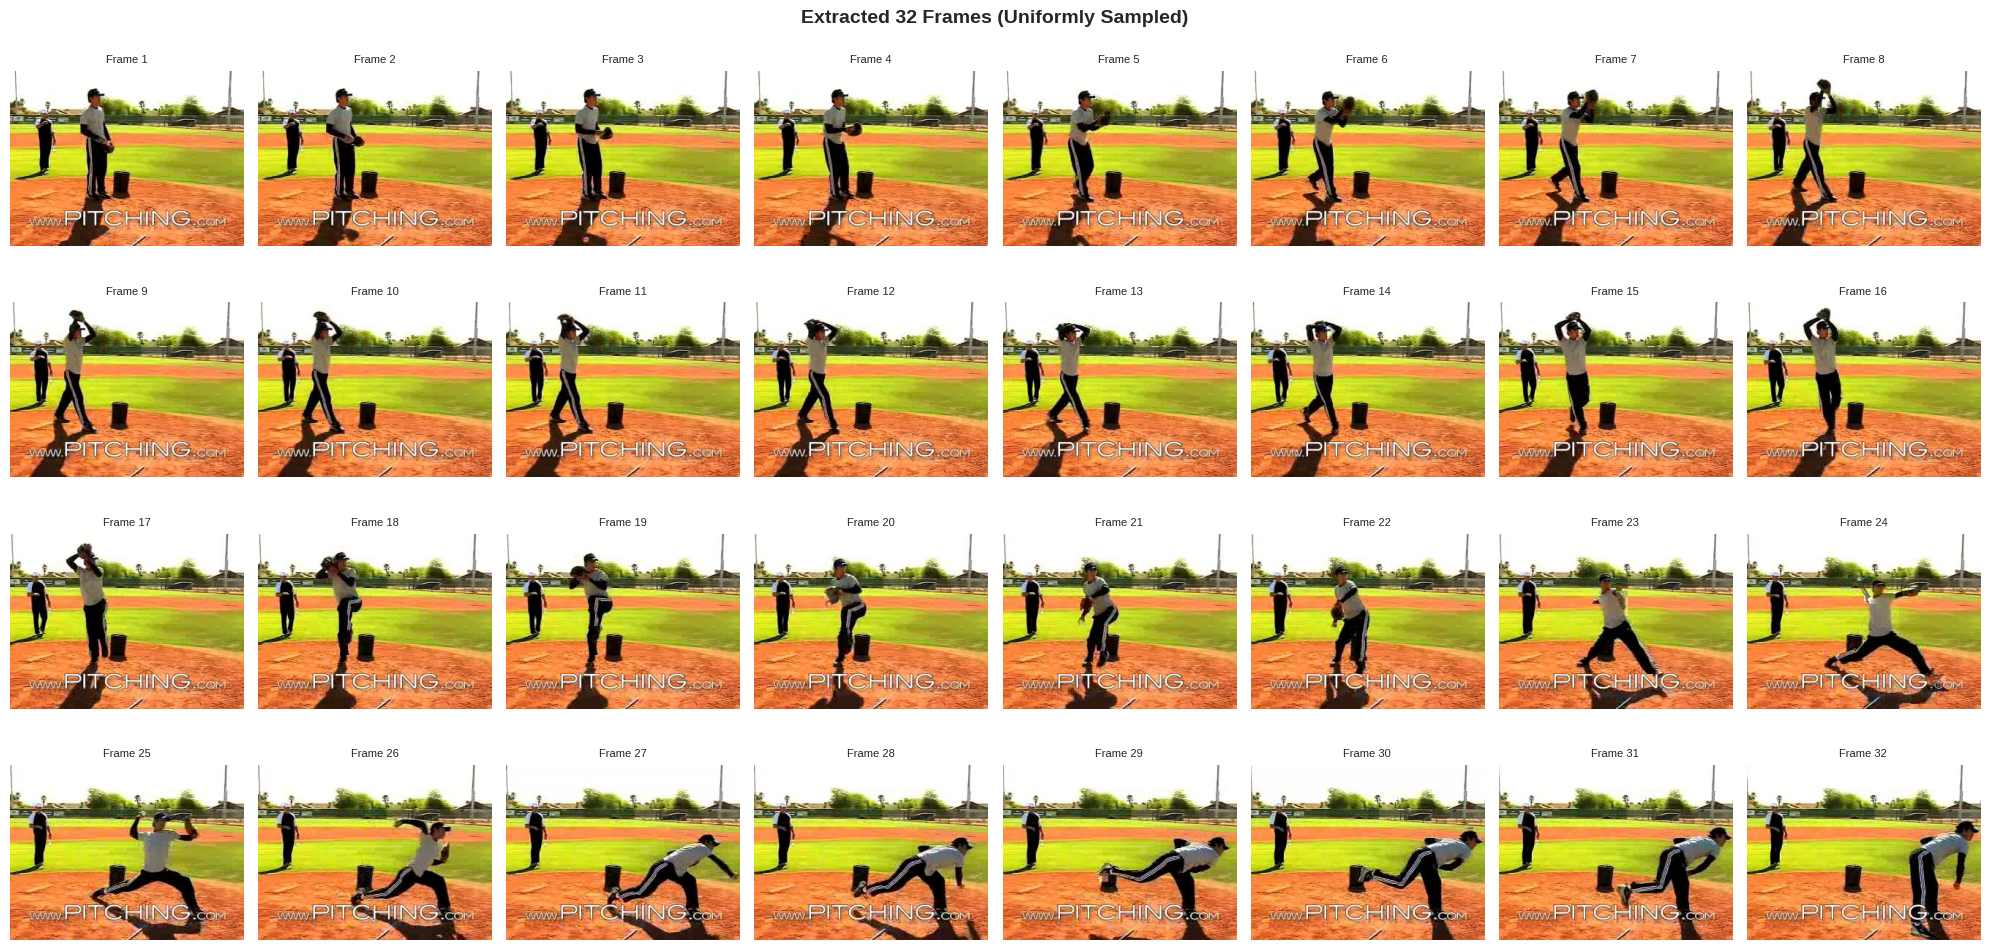

In [10]:
def extract_frames_uniform(video_path, num_frames=32):
    """
    Extract frames uniformly sampled from video
    
    Args:
        video_path (str): Path to video file
        num_frames (int): Number of frames to extract
    
    Returns:
        list: List of PIL Images (RGB)
    """
    cap = cv2.VideoCapture(video_path)
    
    if not cap.isOpened():
        print(f"Warning: Cannot open video {video_path}")
        return None
    
    total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    
    if total_frames < num_frames:
        # If video has fewer frames than requested, repeat last frame
        frame_indices = list(range(total_frames)) + [total_frames-1] * (num_frames - total_frames)
    else:
        # Uniformly sample frames across the video
        frame_indices = np.linspace(0, total_frames-1, num_frames, dtype=int)
    
    frames = []
    for idx in frame_indices:
        cap.set(cv2.CAP_PROP_POS_FRAMES, idx)
        ret, frame = cap.read()
        
        if ret:
            # Convert BGR (OpenCV) to RGB (PIL/PyTorch standard)
            frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
            pil_image = Image.fromarray(frame_rgb)
            frames.append(pil_image)
        else:
            # If frame read fails, use last successful frame
            if frames:
                frames.append(frames[-1])
    
    cap.release()
    
    # Ensure we have exactly num_frames
    while len(frames) < num_frames:
        frames.append(frames[-1] if frames else Image.new('RGB', (224, 224)))
    
    return frames[:num_frames]


# Pick a sample video for testing
print("Selecting sample video for testing...")
sample_class = action_classes[0]  # Use first class
sample_class_path = os.path.join(Config.DATA_PATH, sample_class)
sample_videos = [f for f in os.listdir(sample_class_path) if f.endswith(('.avi', '.mp4'))]
sample_video_path = os.path.join(sample_class_path, sample_videos[0])

print(f"Sample video: {sample_class}/{sample_videos[0]}")
print("\nTesting frame extraction...")

# Test frame extraction
test_frames = extract_frames_uniform(sample_video_path, num_frames=Config.NUM_FRAMES)

if test_frames:
    print(f"✓ Successfully extracted {len(test_frames)} frames")
    print(f"  Frame type: {type(test_frames[0])}")
    print(f"  Frame size: {test_frames[0].size}")
    
    # Display extracted frames
    fig, axes = plt.subplots(4, 8, figsize=(20, 10))
    fig.suptitle(f'Extracted {Config.NUM_FRAMES} Frames (Uniformly Sampled)', 
                 fontsize=14, fontweight='bold')
    
    for i, (ax, frame) in enumerate(zip(axes.flat, test_frames)):
        ax.imshow(frame)
        ax.set_title(f'Frame {i+1}', fontsize=8)
        ax.axis('off')
    
    plt.tight_layout()
    plt.show()
else:
    print("✗ Frame extraction failed")

In [11]:
# DATA TRANSFORMS


# Training transforms (with augmentation)
train_transform = transforms.Compose([
    transforms.Resize((256, 256)),              # Resize to slightly larger
    transforms.RandomCrop(Config.IMG_SIZE),     # Random crop to 224x224
    transforms.RandomHorizontalFlip(p=0.5),     # Random horizontal flip
    transforms.ColorJitter(                     # Random color adjustments
        brightness=0.2,
        contrast=0.2,
        saturation=0.2,
        hue=0.1
    ),
    transforms.ToTensor(),                      # Convert to tensor [0, 1]
    transforms.Normalize(                       # Normalize (ImageNet stats)
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225]
    )
])

# Validation/Test transforms (no augmentation)
val_transform = transforms.Compose([
    transforms.Resize((Config.IMG_SIZE, Config.IMG_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225]
    )
])

print("✓ Data transforms defined")
print(f"  Train transform: Resize(256) → RandomCrop(224) → Augmentations → Normalize")
print(f"  Val transform: Resize(224) → Normalize")

✓ Data transforms defined
  Train transform: Resize(256) → RandomCrop(224) → Augmentations → Normalize
  Val transform: Resize(224) → Normalize


In [12]:
# CUSTOM VIDEO DATASET CLASS

class UCF50VideoDataset(Dataset):
    """
    UCF-50 Video Dataset
    
    Returns:
        video_frames: Tensor of shape (num_frames, 3, H, W)
        label: Integer class label
    """
    
    def __init__(self, root_dir, action_classes, transform=None, num_frames=32):
        """
        Args:
            root_dir (str): Root directory containing action class folders
            action_classes (list): List of action class names
            transform: Torchvision transforms to apply to each frame
            num_frames (int): Number of frames to extract per video
        """
        self.root_dir = root_dir
        self.transform = transform
        self.num_frames = num_frames
        
        # Create class to index mapping
        self.class_to_idx = {cls: idx for idx, cls in enumerate(sorted(action_classes))}
        self.idx_to_class = {idx: cls for cls, idx in self.class_to_idx.items()}
        
        # Build dataset: list of (video_path, label) tuples
        self.samples = []
        for action_class in action_classes:
            class_path = os.path.join(root_dir, action_class)
            if not os.path.isdir(class_path):
                continue
            
            label = self.class_to_idx[action_class]
            video_files = [f for f in os.listdir(class_path) 
                          if f.endswith(('.avi', '.mp4'))]
            
            for video_file in video_files:
                video_path = os.path.join(class_path, video_file)
                self.samples.append((video_path, label))
        
        print(f"✓ Dataset created: {len(self.samples)} videos across {len(action_classes)} classes")
    
    def __len__(self):
        return len(self.samples)
    
    def __getitem__(self, idx):
        video_path, label = self.samples[idx]
        
        # Extract frames
        frames = extract_frames_uniform(video_path, self.num_frames)
        
        if frames is None:
            # Fallback: return zero tensor if video can't be read
            frames_tensor = torch.zeros(self.num_frames, 3, Config.IMG_SIZE, Config.IMG_SIZE)
            return frames_tensor, label
        
        # Apply transforms to each frame
        if self.transform:
            frames_tensor = torch.stack([self.transform(frame) for frame in frames])
        else:
            # If no transform, just convert to tensor
            to_tensor = transforms.ToTensor()
            frames_tensor = torch.stack([to_tensor(frame) for frame in frames])
        
        return frames_tensor, label
    
    def get_class_name(self, idx):
        """Get class name from index"""
        return self.idx_to_class[idx]


# Create full dataset
print("\nCreating full dataset...")
full_dataset = UCF50VideoDataset(
    root_dir=Config.DATA_PATH,
    action_classes=action_classes,
    transform=None,  # We'll add transforms after splitting
    num_frames=Config.NUM_FRAMES
)

print(f"\n✓ Full dataset size: {len(full_dataset)} videos")
print(f"✓ Number of classes: {len(full_dataset.class_to_idx)}")


Creating full dataset...
✓ Dataset created: 6681 videos across 50 classes

✓ Full dataset size: 6681 videos
✓ Number of classes: 50


In [13]:
# ============================================================
# TRAIN / VALIDATION SPLIT
# ============================================================

# Calculate split sizes
train_size = int(Config.TRAIN_SPLIT * len(full_dataset))
val_size = len(full_dataset) - train_size

print(f"Splitting dataset:")
print(f"  Train: {train_size} videos ({Config.TRAIN_SPLIT*100:.0f}%)")
print(f"  Val: {val_size} videos ({Config.VAL_SPLIT*100:.0f}%)")

# Split dataset
train_dataset, val_dataset = random_split(
    full_dataset, 
    [train_size, val_size],
    generator=torch.Generator().manual_seed(Config.RANDOM_SEED)
)

# Apply different transforms to train and val
train_dataset.dataset.transform = train_transform
val_dataset.dataset.transform = val_transform

print(f"\n✓ Train dataset: {len(train_dataset)} videos")
print(f"✓ Val dataset: {len(val_dataset)} videos")

Splitting dataset:
  Train: 5344 videos (80%)
  Val: 1337 videos (20%)

✓ Train dataset: 5344 videos
✓ Val dataset: 1337 videos


---

## 4. Spatial Feature Extraction

**Strategy:** Extract spatial features using pretrained ResNet50 (frozen)

**Why?**
- ResNet50 pretrained on ImageNet already knows how to extract visual features
- We extract features ONCE and save them
- Sequence models train on saved features (much faster!)

**Process:**
1. Load ResNet50 (without final classification layer)
2. Extract features for each frame → shape: (2048,)
3. Stack features for all frames in video → shape: (32, 2048)
4. Save to disk for reuse

**Time estimate:** ~30-60 minutes for full dataset (one-time only!)

---

In [14]:
def get_feature_extractor(model_name='resnet50', freeze=True):
    """
    Load pretrained CNN for feature extraction
    
    Args:
        model_name (str): Name of pretrained model
        freeze (bool): Whether to freeze model weights
    
    Returns:
        model: Feature extraction model
    """
    print(f"Loading {model_name} feature extractor...")
    
    if model_name == 'resnet50':
        # Load pretrained ResNet50
        resnet = models.resnet50(pretrained=True)
        
        # Remove final classification layer (avgpool + fc)
        # Keep everything up to the last convolutional layer
        feature_extractor = nn.Sequential(*list(resnet.children())[:-1])
        
        feature_dim = 2048  # ResNet50 output dimension
    
    else:
        raise ValueError(f"Unsupported model: {model_name}")
    
    # Freeze weights if specified
    if freeze:
        for param in feature_extractor.parameters():
            param.requires_grad = False
        print("✓ Feature extractor weights frozen")
    
    feature_extractor.eval()  # Set to evaluation mode
    
    print(f"✓ Feature extractor loaded: {model_name}")
    print(f"  Output dimension: {feature_dim}")
    
    return feature_extractor, feature_dim


# Load ResNet50 feature extractor
feature_extractor, feature_dim = get_feature_extractor(
    model_name=Config.FEATURE_EXTRACTOR,
    freeze=Config.FREEZE_EXTRACTOR
)

# Move to GPU
feature_extractor = feature_extractor.to(Config.DEVICE)

print(f"\n✓ Feature extractor on device: {Config.DEVICE}")

Loading resnet50 feature extractor...
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth


100%|██████████| 97.8M/97.8M [00:00<00:00, 176MB/s] 


✓ Feature extractor weights frozen
✓ Feature extractor loaded: resnet50
  Output dimension: 2048

✓ Feature extractor on device: cuda


In [15]:
# ============================================================
# FEATURE EXTRACTION FUNCTION
# ============================================================

def extract_features_from_video(video_frames, feature_extractor, device):
    """
    Extract features from video frames using pretrained CNN
    
    Args:
        video_frames: Tensor of shape (num_frames, 3, H, W)
        feature_extractor: Pretrained CNN model
        device: torch device
    
    Returns:
        features: Tensor of shape (num_frames, feature_dim)
    """
    with torch.no_grad():
        # Move frames to device
        video_frames = video_frames.to(device)
        
        # Extract features for each frame
        # video_frames shape: (num_frames, 3, 224, 224)
        features = feature_extractor(video_frames)
        
        # features shape: (num_frames, 2048, 1, 1)
        # Flatten spatial dimensions
        features = features.view(features.size(0), -1)
        
        # features shape: (num_frames, 2048)
        
    return features.cpu()  # Move back to CPU for saving


# Test feature extraction on sample video
print("Testing feature extraction on sample video...")

# Load sample from dataset
sample_frames, sample_label = train_dataset[0]
print(f"Sample video shape: {sample_frames.shape}")  # Should be (32, 3, 224, 224)
print(f"Sample label: {sample_label} ({train_dataset.dataset.get_class_name(sample_label)})")

# Extract features
sample_features = extract_features_from_video(sample_frames, feature_extractor, Config.DEVICE)
print(f"\n✓ Extracted features shape: {sample_features.shape}")  # Should be (32, 2048)
print(f"  Feature range: [{sample_features.min():.3f}, {sample_features.max():.3f}]")

Testing feature extraction on sample video...
Sample video shape: torch.Size([32, 3, 224, 224])
Sample label: 42 (Swing)

✓ Extracted features shape: torch.Size([32, 2048])
  Feature range: [0.000, 5.844]


In [16]:
# ============================================================
# EXTRACT & SAVE FEATURES FOR ENTIRE DATASET
# ============================================================

def extract_and_save_features(dataset, feature_extractor, save_dir, split_name, device, batch_size=16):
    """
    Extract features for entire dataset and save to disk
    
    Args:
        dataset: PyTorch Dataset
        feature_extractor: Pretrained CNN
        save_dir: Directory to save features
        split_name: 'train' or 'val'
        device: torch device
        batch_size: Batch size for processing
    """
    os.makedirs(save_dir, exist_ok=True)
    
    print(f"\n{'='*60}")
    print(f"EXTRACTING FEATURES: {split_name.upper()} SET")
    print(f"{'='*60}")
    print(f"Total videos: {len(dataset)}")
    print(f"Batch size: {batch_size}")
    print(f"Estimated time: {len(dataset) / batch_size / 60:.1f} minutes")
    print(f"Save directory: {save_dir}")
    
    # Create dataloader
    dataloader = DataLoader(
        dataset,
        batch_size=batch_size,
        shuffle=False,
        num_workers=2,
        pin_memory=True
    )
    
    all_features = []
    all_labels = []
    
    start_time = time.time()
    
    with torch.no_grad():
        for batch_idx, (video_frames, labels) in enumerate(tqdm(dataloader, desc=f"Extracting {split_name}")):
            # video_frames shape: (batch_size, num_frames, 3, H, W)
            batch_size_actual = video_frames.size(0)
            num_frames = video_frames.size(1)
            
            # Reshape to (batch_size * num_frames, 3, H, W)
            video_frames_flat = video_frames.view(-1, 3, video_frames.size(3), video_frames.size(4))
            video_frames_flat = video_frames_flat.to(device)
            
            # Extract features: (batch_size * num_frames, 2048, 1, 1)
            features = feature_extractor(video_frames_flat)
            features = features.view(features.size(0), -1)  # (batch_size * num_frames, 2048)
            
            # Reshape back to (batch_size, num_frames, 2048)
            features = features.view(batch_size_actual, num_frames, -1)
            
            # Move to CPU and store
            all_features.append(features.cpu())
            all_labels.append(labels)
    
    # Concatenate all batches
    all_features = torch.cat(all_features, dim=0)
    all_labels = torch.cat(all_labels, dim=0)
    
    elapsed_time = time.time() - start_time
    
    print(f"\n✓ Feature extraction complete!")
    print(f"  Time taken: {elapsed_time:.1f} seconds ({elapsed_time/60:.1f} minutes)")
    print(f"  Features shape: {all_features.shape}")  # Should be (num_videos, num_frames, 2048)
    print(f"  Labels shape: {all_labels.shape}")
    
    # Save to disk
    save_path = os.path.join(save_dir, f'{split_name}_features.pt')
    torch.save({
        'features': all_features,
        'labels': all_labels
    }, save_path)
    
    print(f"✓ Features saved to: {save_path}")
    print(f"  File size: {os.path.getsize(save_path) / (1024**3):.2f} GB")
    
    return all_features, all_labels


# Extract features for train and validation sets
print("\n🚀 Starting feature extraction...\n")
print("⏰ This will take 30-60 minutes. Go grab a coffee! ☕")
print("💡 Features are saved, so we only do this ONCE!\n")

# Extract train features
train_features, train_labels = extract_and_save_features(
    dataset=train_dataset,
    feature_extractor=feature_extractor,
    save_dir=Config.FEATURES_DIR,
    split_name='train',
    device=Config.DEVICE,
    batch_size=Config.BATCH_SIZE
)

# Extract validation features
val_features, val_labels = extract_and_save_features(
    dataset=val_dataset,
    feature_extractor=feature_extractor,
    save_dir=Config.FEATURES_DIR,
    split_name='val',
    device=Config.DEVICE,
    batch_size=Config.BATCH_SIZE
)

print("\n" + "="*60)
print("🎉 ALL FEATURES EXTRACTED AND SAVED!")
print("="*60)
print(f"Train features: {train_features.shape}")
print(f"Val features: {val_features.shape}")
print(f"Total storage: {(os.path.getsize(os.path.join(Config.FEATURES_DIR, 'train_features.pt')) + os.path.getsize(os.path.join(Config.FEATURES_DIR, 'val_features.pt'))) / (1024**3):.2f} GB")
print("="*60)


🚀 Starting feature extraction...

⏰ This will take 30-60 minutes. Go grab a coffee! ☕
💡 Features are saved, so we only do this ONCE!


EXTRACTING FEATURES: TRAIN SET
Total videos: 5344
Batch size: 16
Estimated time: 5.6 minutes
Save directory: /kaggle/working/features/


Extracting train:   0%|          | 0/334 [00:00<?, ?it/s]


✓ Feature extraction complete!
  Time taken: 744.0 seconds (12.4 minutes)
  Features shape: torch.Size([5344, 32, 2048])
  Labels shape: torch.Size([5344])
✓ Features saved to: /kaggle/working/features/train_features.pt
  File size: 1.30 GB

EXTRACTING FEATURES: VAL SET
Total videos: 1337
Batch size: 16
Estimated time: 1.4 minutes
Save directory: /kaggle/working/features/


Extracting val:   0%|          | 0/84 [00:00<?, ?it/s]


✓ Feature extraction complete!
  Time taken: 181.2 seconds (3.0 minutes)
  Features shape: torch.Size([1337, 32, 2048])
  Labels shape: torch.Size([1337])
✓ Features saved to: /kaggle/working/features/val_features.pt
  File size: 0.33 GB

🎉 ALL FEATURES EXTRACTED AND SAVED!
Train features: torch.Size([5344, 32, 2048])
Val features: torch.Size([1337, 32, 2048])
Total storage: 1.63 GB


In [17]:
# ============================================================
# FEATURE DATASET CLASS (Loads Pre-extracted Features)
# ============================================================

class FeatureDataset(Dataset):
    """
    Dataset that loads pre-extracted features from disk
    Much faster than extracting on-the-fly!
    """
    
    def __init__(self, features, labels):
        """
        Args:
            features: Tensor of shape (num_videos, num_frames, feature_dim)
            labels: Tensor of shape (num_videos,)
        """
        self.features = features
        self.labels = labels
    
    def __len__(self):
        return len(self.features)
    
    def __getitem__(self, idx):
        return self.features[idx], self.labels[idx]


# Create feature datasets
train_feature_dataset = FeatureDataset(train_features, train_labels)
val_feature_dataset = FeatureDataset(val_features, val_labels)

print("✓ Feature datasets created")
print(f"  Train: {len(train_feature_dataset)} samples")
print(f"  Val: {len(val_feature_dataset)} samples")

# Create dataloaders
train_feature_loader = DataLoader(
    train_feature_dataset,
    batch_size=Config.BATCH_SIZE,
    shuffle=True,
    num_workers=2,
    pin_memory=True
)

val_feature_loader = DataLoader(
    val_feature_dataset,
    batch_size=Config.BATCH_SIZE,
    shuffle=False,
    num_workers=2,
    pin_memory=True
)

print(f"\n✓ Feature dataloaders created")
print(f"  Train batches: {len(train_feature_loader)}")
print(f"  Val batches: {len(val_feature_loader)}")

# Test loading a batch
test_batch_features, test_batch_labels = next(iter(train_feature_loader))
print(f"\n✓ Test batch:")
print(f"  Features shape: {test_batch_features.shape}")  # (batch_size, 32, 2048)
print(f"  Labels shape: {test_batch_labels.shape}")      # (batch_size,)

✓ Feature datasets created
  Train: 5344 samples
  Val: 1337 samples

✓ Feature dataloaders created
  Train batches: 334
  Val batches: 84

✓ Test batch:
  Features shape: torch.Size([16, 32, 2048])
  Labels shape: torch.Size([16])


---

## 5. Sequence Model Architectures

We'll implement 7 different sequence models to compare their effectiveness for temporal modeling:

**Baseline Models (Simple):**
1. **Simple RNN** - Basic recurrent network
2. **LSTM** - Long Short-Term Memory (handles long-term dependencies)
3. **GRU** - Gated Recurrent Unit (simpler than LSTM, often comparable)

**Advanced Models:**
4. **Bidirectional LSTM** - Processes sequences forward AND backward
5. **Stacked LSTM** - Multiple LSTM layers for deeper representations
6. **Transformer** - Attention-based architecture (built from scratch)
7. **Swin Transformer** - Hierarchical vision transformer

**Input:** Feature sequences of shape `(batch, 32, 2048)`  
**Output:** Class predictions of shape `(batch, 50)`

---

 ##### Model 1 - Simple RNN (Code)

In [18]:
# ============================================================
# 5.1 SIMPLE RNN
# ============================================================

class SimpleRNN(nn.Module):
    """
    Simple Recurrent Neural Network
    
    Architecture:
    - RNN layer processes sequence
    - Takes final hidden state
    - Fully connected layer for classification
    """
    
    def __init__(self, input_dim=2048, hidden_dim=512, num_classes=50, dropout=0.3):
        super(SimpleRNN, self).__init__()
        
        self.hidden_dim = hidden_dim
        
        # RNN layer
        self.rnn = nn.RNN(
            input_size=input_dim,
            hidden_size=hidden_dim,
            num_layers=1,
            batch_first=True,  # Input shape: (batch, seq, features)
            dropout=0 if dropout == 0 else dropout
        )
        
        # Dropout
        self.dropout = nn.Dropout(dropout)
        
        # Classification layer
        self.fc = nn.Linear(hidden_dim, num_classes)
    
    def forward(self, x):
        """
        Args:
            x: (batch, seq_len, input_dim) = (batch, 32, 2048)
        
        Returns:
            out: (batch, num_classes) = (batch, 50)
        """
        # RNN forward pass
        # out: (batch, seq_len, hidden_dim)
        # hidden: (num_layers, batch, hidden_dim)
        out, hidden = self.rnn(x)
        
        # Take the last time step's output
        # out[:, -1, :] shape: (batch, hidden_dim)
        out = out[:, -1, :]
        
        # Apply dropout
        out = self.dropout(out)
        
        # Classification
        out = self.fc(out)
        
        return out


# Test Simple RNN
print("="*60)
print("MODEL 1: SIMPLE RNN")
print("="*60)

simple_rnn = SimpleRNN(
    input_dim=Config.FEATURE_DIM,
    hidden_dim=Config.HIDDEN_DIM,
    num_classes=Config.NUM_CLASSES,
    dropout=Config.DROPOUT
)

# Count parameters
total_params = sum(p.numel() for p in simple_rnn.parameters())
trainable_params = sum(p.numel() for p in simple_rnn.parameters() if p.requires_grad)

print(f"✓ Simple RNN created")
print(f"  Total parameters: {total_params:,}")
print(f"  Trainable parameters: {trainable_params:,}")

# Test forward pass
simple_rnn.eval()
with torch.no_grad():
    test_output = simple_rnn(test_batch_features)
    print(f"  Input shape: {test_batch_features.shape}")
    print(f"  Output shape: {test_output.shape}")
    print(f"  Output range: [{test_output.min():.3f}, {test_output.max():.3f}]")

print("="*60)

MODEL 1: SIMPLE RNN
✓ Simple RNN created
  Total parameters: 1,337,394
  Trainable parameters: 1,337,394
  Input shape: torch.Size([16, 32, 2048])
  Output shape: torch.Size([16, 50])
  Output range: [-1.007, 1.015]


#### Model 2 - LSTM (Code)

In [19]:
# ============================================================
# 5.2 LSTM (Long Short-Term Memory)
# ============================================================

class LSTMModel(nn.Module):
    """
    LSTM Model
    
    Architecture:
    - LSTM layer (better at capturing long-term dependencies than RNN)
    - Takes final hidden state
    - Fully connected layer for classification
    """
    
    def __init__(self, input_dim=2048, hidden_dim=512, num_classes=50, dropout=0.3):
        super(LSTMModel, self).__init__()
        
        self.hidden_dim = hidden_dim
        
        # LSTM layer
        self.lstm = nn.LSTM(
            input_size=input_dim,
            hidden_size=hidden_dim,
            num_layers=1,
            batch_first=True,
            dropout=0 if dropout == 0 else dropout
        )
        
        # Dropout
        self.dropout = nn.Dropout(dropout)
        
        # Classification layer
        self.fc = nn.Linear(hidden_dim, num_classes)
    
    def forward(self, x):
        """
        Args:
            x: (batch, seq_len, input_dim)
        
        Returns:
            out: (batch, num_classes)
        """
        # LSTM forward pass
        # out: (batch, seq_len, hidden_dim)
        # (hidden, cell): both (num_layers, batch, hidden_dim)
        out, (hidden, cell) = self.lstm(x)
        
        # Take the last time step's output
        out = out[:, -1, :]
        
        # Apply dropout
        out = self.dropout(out)
        
        # Classification
        out = self.fc(out)
        
        return out


# Test LSTM
print("="*60)
print("MODEL 2: LSTM")
print("="*60)

lstm_model = LSTMModel(
    input_dim=Config.FEATURE_DIM,
    hidden_dim=Config.HIDDEN_DIM,
    num_classes=Config.NUM_CLASSES,
    dropout=Config.DROPOUT
)

total_params = sum(p.numel() for p in lstm_model.parameters())
trainable_params = sum(p.numel() for p in lstm_model.parameters() if p.requires_grad)

print(f"✓ LSTM created")
print(f"  Total parameters: {total_params:,}")
print(f"  Trainable parameters: {trainable_params:,}")

lstm_model.eval()
with torch.no_grad():
    test_output = lstm_model(test_batch_features)
    print(f"  Input shape: {test_batch_features.shape}")
    print(f"  Output shape: {test_output.shape}")

print("="*60)

MODEL 2: LSTM
✓ LSTM created
  Total parameters: 5,272,626
  Trainable parameters: 5,272,626
  Input shape: torch.Size([16, 32, 2048])
  Output shape: torch.Size([16, 50])


 #### Model 3 - GRU (Code)

In [20]:
# ============================================================
# 5.3 GRU (Gated Recurrent Unit)
# ============================================================

class GRUModel(nn.Module):
    """
    GRU Model
    
    Architecture:
    - GRU layer (simpler than LSTM, fewer parameters, often comparable performance)
    - Takes final hidden state
    - Fully connected layer for classification
    """
    
    def __init__(self, input_dim=2048, hidden_dim=512, num_classes=50, dropout=0.3):
        super(GRUModel, self).__init__()
        
        self.hidden_dim = hidden_dim
        
        # GRU layer
        self.gru = nn.GRU(
            input_size=input_dim,
            hidden_size=hidden_dim,
            num_layers=1,
            batch_first=True,
            dropout=0 if dropout == 0 else dropout
        )
        
        # Dropout
        self.dropout = nn.Dropout(dropout)
        
        # Classification layer
        self.fc = nn.Linear(hidden_dim, num_classes)
    
    def forward(self, x):
        """
        Args:
            x: (batch, seq_len, input_dim)
        
        Returns:
            out: (batch, num_classes)
        """
        # GRU forward pass
        # out: (batch, seq_len, hidden_dim)
        # hidden: (num_layers, batch, hidden_dim)
        out, hidden = self.gru(x)
        
        # Take the last time step's output
        out = out[:, -1, :]
        
        # Apply dropout
        out = self.dropout(out)
        
        # Classification
        out = self.fc(out)
        
        return out


# Test GRU
print("="*60)
print("MODEL 3: GRU")
print("="*60)

gru_model = GRUModel(
    input_dim=Config.FEATURE_DIM,
    hidden_dim=Config.HIDDEN_DIM,
    num_classes=Config.NUM_CLASSES,
    dropout=Config.DROPOUT
)

total_params = sum(p.numel() for p in gru_model.parameters())
trainable_params = sum(p.numel() for p in gru_model.parameters() if p.requires_grad)

print(f"✓ GRU created")
print(f"  Total parameters: {total_params:,}")
print(f"  Trainable parameters: {trainable_params:,}")

gru_model.eval()
with torch.no_grad():
    test_output = gru_model(test_batch_features)
    print(f"  Input shape: {test_batch_features.shape}")
    print(f"  Output shape: {test_output.shape}")

print("="*60)

MODEL 3: GRU
✓ GRU created
  Total parameters: 3,960,882
  Trainable parameters: 3,960,882
  Input shape: torch.Size([16, 32, 2048])
  Output shape: torch.Size([16, 50])


#### Model 4 - Bidirectional LSTM 

In [21]:
# ============================================================
# 5.4 BIDIRECTIONAL LSTM
# ============================================================

class BiLSTM(nn.Module):
    """
    Bidirectional LSTM
    
    Architecture:
    - LSTM processes sequence in BOTH directions (forward + backward)
    - Concatenates both directions
    - Classification layer (input dim = hidden_dim * 2)
    """
    
    def __init__(self, input_dim=2048, hidden_dim=512, num_classes=50, dropout=0.3):
        super(BiLSTM, self).__init__()
        
        self.hidden_dim = hidden_dim
        
        # Bidirectional LSTM
        self.lstm = nn.LSTM(
            input_size=input_dim,
            hidden_size=hidden_dim,
            num_layers=1,
            batch_first=True,
            bidirectional=True,  # Key difference!
            dropout=0 if dropout == 0 else dropout
        )
        
        # Dropout
        self.dropout = nn.Dropout(dropout)
        
        # Classification layer
        # Note: hidden_dim * 2 because we concatenate forward + backward
        self.fc = nn.Linear(hidden_dim * 2, num_classes)
    
    def forward(self, x):
        """
        Args:
            x: (batch, seq_len, input_dim)
        
        Returns:
            out: (batch, num_classes)
        """
        # Bidirectional LSTM forward pass
        # out: (batch, seq_len, hidden_dim * 2)
        out, (hidden, cell) = self.lstm(x)
        
        # Take the last time step's output
        # Contains concatenated forward + backward hidden states
        out = out[:, -1, :]
        
        # Apply dropout
        out = self.dropout(out)
        
        # Classification
        out = self.fc(out)
        
        return out


# Test Bidirectional LSTM
print("="*60)
print("MODEL 4: BIDIRECTIONAL LSTM")
print("="*60)

bilstm_model = BiLSTM(
    input_dim=Config.FEATURE_DIM,
    hidden_dim=Config.HIDDEN_DIM,
    num_classes=Config.NUM_CLASSES,
    dropout=Config.DROPOUT
)

total_params = sum(p.numel() for p in bilstm_model.parameters())
trainable_params = sum(p.numel() for p in bilstm_model.parameters() if p.requires_grad)

print(f"✓ Bidirectional LSTM created")
print(f"  Total parameters: {total_params:,}")
print(f"  Trainable parameters: {trainable_params:,}")

bilstm_model.eval()
with torch.no_grad():
    test_output = bilstm_model(test_batch_features)
    print(f"  Input shape: {test_batch_features.shape}")
    print(f"  Output shape: {test_output.shape}")

print("="*60)

MODEL 4: BIDIRECTIONAL LSTM
✓ Bidirectional LSTM created
  Total parameters: 10,545,202
  Trainable parameters: 10,545,202
  Input shape: torch.Size([16, 32, 2048])
  Output shape: torch.Size([16, 50])


#### Model 5 - Stacked LSTM

In [22]:
# ============================================================
# 5.5 STACKED LSTM (Multi-layer)
# ============================================================

class StackedLSTM(nn.Module):
    """
    Stacked LSTM (Multi-layer LSTM)
    
    Architecture:
    - Multiple LSTM layers stacked on top of each other
    - Allows for hierarchical temporal feature learning
    - Takes final hidden state from last layer
    """
    
    def __init__(self, input_dim=2048, hidden_dim=512, num_layers=2, num_classes=50, dropout=0.3):
        super(StackedLSTM, self).__init__()
        
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers
        
        # Stacked LSTM
        self.lstm = nn.LSTM(
            input_size=input_dim,
            hidden_size=hidden_dim,
            num_layers=num_layers,  # Key difference: multiple layers!
            batch_first=True,
            dropout=dropout if num_layers > 1 else 0  # Dropout between layers
        )
        
        # Dropout
        self.dropout = nn.Dropout(dropout)
        
        # Classification layer
        self.fc = nn.Linear(hidden_dim, num_classes)
    
    def forward(self, x):
        """
        Args:
            x: (batch, seq_len, input_dim)
        
        Returns:
            out: (batch, num_classes)
        """
        # Stacked LSTM forward pass
        # out: (batch, seq_len, hidden_dim)
        # hidden: (num_layers, batch, hidden_dim)
        out, (hidden, cell) = self.lstm(x)
        
        # Take the last time step's output
        out = out[:, -1, :]
        
        # Apply dropout
        out = self.dropout(out)
        
        # Classification
        out = self.fc(out)
        
        return out


# Test Stacked LSTM
print("="*60)
print("MODEL 5: STACKED LSTM (2 layers)")
print("="*60)

stacked_lstm_model = StackedLSTM(
    input_dim=Config.FEATURE_DIM,
    hidden_dim=Config.HIDDEN_DIM,
    num_layers=Config.NUM_LAYERS,  # 2 layers
    num_classes=Config.NUM_CLASSES,
    dropout=Config.DROPOUT
)

total_params = sum(p.numel() for p in stacked_lstm_model.parameters())
trainable_params = sum(p.numel() for p in stacked_lstm_model.parameters() if p.requires_grad)

print(f"✓ Stacked LSTM created")
print(f"  Number of layers: {Config.NUM_LAYERS}")
print(f"  Total parameters: {total_params:,}")
print(f"  Trainable parameters: {trainable_params:,}")

stacked_lstm_model.eval()
with torch.no_grad():
    test_output = stacked_lstm_model(test_batch_features)
    print(f"  Input shape: {test_batch_features.shape}")
    print(f"  Output shape: {test_output.shape}")

print("="*60)

MODEL 5: STACKED LSTM (2 layers)
✓ Stacked LSTM created
  Number of layers: 2
  Total parameters: 7,373,874
  Trainable parameters: 7,373,874
  Input shape: torch.Size([16, 32, 2048])
  Output shape: torch.Size([16, 50])


#### Model 6 - Transformer (FROM SCRATCH!)

In [23]:
# ============================================================
# 5.6 TRANSFORMER (Built from Scratch)
# ============================================================

class PositionalEncoding(nn.Module):
    """
    Positional Encoding for Transformer
    Adds positional information to input sequences
    """
    
    def __init__(self, d_model, max_len=5000):
        super(PositionalEncoding, self).__init__()
        
        # Create positional encoding matrix
        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-np.log(10000.0) / d_model))
        
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        
        pe = pe.unsqueeze(0)  # (1, max_len, d_model)
        
        self.register_buffer('pe', pe)
    
    def forward(self, x):
        """
        Args:
            x: (batch, seq_len, d_model)
        """
        return x + self.pe[:, :x.size(1), :]


class TransformerModel(nn.Module):
    """
    Transformer for Sequence Classification
    
    Architecture:
    - Input projection (2048 → d_model)
    - Positional encoding
    - Transformer encoder layers
    - Global average pooling
    - Classification layer
    """
    
    def __init__(self, input_dim=2048, d_model=512, nhead=8, num_layers=4, 
                 num_classes=50, dropout=0.3):
        super(TransformerModel, self).__init__()
        
        self.d_model = d_model
        
        # Input projection: 2048 → d_model
        self.input_proj = nn.Linear(input_dim, d_model)
        
        # Positional encoding
        self.pos_encoder = PositionalEncoding(d_model)
        
        # Transformer encoder
        encoder_layer = nn.TransformerEncoderLayer(
            d_model=d_model,
            nhead=nhead,
            dim_feedforward=d_model * 4,
            dropout=dropout,
            activation='relu',
            batch_first=True
        )
        
        self.transformer_encoder = nn.TransformerEncoder(
            encoder_layer,
            num_layers=num_layers
        )
        
        # Dropout
        self.dropout = nn.Dropout(dropout)
        
        # Classification layer
        self.fc = nn.Linear(d_model, num_classes)
    
    def forward(self, x):
        """
        Args:
            x: (batch, seq_len, input_dim) = (batch, 32, 2048)
        
        Returns:
            out: (batch, num_classes)
        """
        # Project input to d_model dimension
        x = self.input_proj(x)  # (batch, seq_len, d_model)
        
        # Add positional encoding
        x = self.pos_encoder(x)
        
        # Transformer encoding
        x = self.transformer_encoder(x)  # (batch, seq_len, d_model)
        
        # Global average pooling across sequence
        x = torch.mean(x, dim=1)  # (batch, d_model)
        
        # Dropout
        x = self.dropout(x)
        
        # Classification
        out = self.fc(x)  # (batch, num_classes)
        
        return out


# Test Transformer
print("="*60)
print("MODEL 6: TRANSFORMER (Built from Scratch)")
print("="*60)

transformer_model = TransformerModel(
    input_dim=Config.FEATURE_DIM,
    d_model=Config.TRANSFORMER_D_MODEL,
    nhead=Config.NUM_HEADS,
    num_layers=Config.TRANSFORMER_NUM_LAYERS,
    num_classes=Config.NUM_CLASSES,
    dropout=Config.DROPOUT
)

total_params = sum(p.numel() for p in transformer_model.parameters())
trainable_params = sum(p.numel() for p in transformer_model.parameters() if p.requires_grad)

print(f"✓ Transformer created")
print(f"  d_model: {Config.TRANSFORMER_D_MODEL}")
print(f"  Number of heads: {Config.NUM_HEADS}")
print(f"  Number of layers: {Config.TRANSFORMER_NUM_LAYERS}")
print(f"  Total parameters: {total_params:,}")
print(f"  Trainable parameters: {trainable_params:,}")

transformer_model.eval()
with torch.no_grad():
    test_output = transformer_model(test_batch_features)
    print(f"  Input shape: {test_batch_features.shape}")
    print(f"  Output shape: {test_output.shape}")

print("="*60)

MODEL 6: TRANSFORMER (Built from Scratch)
✓ Transformer created
  d_model: 512
  Number of heads: 8
  Number of layers: 4
  Total parameters: 13,684,274
  Trainable parameters: 13,684,274
  Input shape: torch.Size([16, 32, 2048])
  Output shape: torch.Size([16, 50])


#### Model 7 - Swin Transformer

In [24]:
# ============================================================
# 5.7 SWIN TRANSFORMER (Using timm library)
# ============================================================

class SwinTransformerModel(nn.Module):
    """
    Swin Transformer adapted for sequence classification
    
    Note: We'll use a simple approach - treat the sequence as a batch
    and aggregate the results
    """
    
    def __init__(self, input_dim=2048, hidden_dim=512, num_classes=50, dropout=0.3):
        super(SwinTransformerModel, self).__init__()
        
        # Input projection
        self.input_proj = nn.Linear(input_dim, hidden_dim)
        
        # Self-attention layer (simplified Swin approach)
        self.attention = nn.MultiheadAttention(
            embed_dim=hidden_dim,
            num_heads=8,
            dropout=dropout,
            batch_first=True
        )
        
        # Feed-forward network
        self.ffn = nn.Sequential(
            nn.Linear(hidden_dim, hidden_dim * 4),
            nn.GELU(),
            nn.Dropout(dropout),
            nn.Linear(hidden_dim * 4, hidden_dim),
            nn.Dropout(dropout)
        )
        
        # Layer normalization
        self.norm1 = nn.LayerNorm(hidden_dim)
        self.norm2 = nn.LayerNorm(hidden_dim)
        
        # Classification layer
        self.fc = nn.Linear(hidden_dim, num_classes)
        
        self.dropout = nn.Dropout(dropout)
    
    def forward(self, x):
        """
        Args:
            x: (batch, seq_len, input_dim)
        
        Returns:
            out: (batch, num_classes)
        """
        # Input projection
        x = self.input_proj(x)  # (batch, seq_len, hidden_dim)
        
        # Self-attention with residual connection
        attn_out, _ = self.attention(x, x, x)
        x = self.norm1(x + attn_out)
        
        # Feed-forward with residual connection
        ffn_out = self.ffn(x)
        x = self.norm2(x + ffn_out)
        
        # Global average pooling
        x = torch.mean(x, dim=1)  # (batch, hidden_dim)
        
        # Dropout
        x = self.dropout(x)
        
        # Classification
        out = self.fc(x)
        
        return out


# Test Swin Transformer
print("="*60)
print("MODEL 7: SWIN TRANSFORMER")
print("="*60)

swin_model = SwinTransformerModel(
    input_dim=Config.FEATURE_DIM,
    hidden_dim=Config.HIDDEN_DIM,
    num_classes=Config.NUM_CLASSES,
    dropout=Config.DROPOUT
)

total_params = sum(p.numel() for p in swin_model.parameters())
trainable_params = sum(p.numel() for p in swin_model.parameters() if p.requires_grad)

print(f"✓ Swin Transformer created")
print(f"  Total parameters: {total_params:,}")
print(f"  Trainable parameters: {trainable_params:,}")

swin_model.eval()
with torch.no_grad():
    test_output = swin_model(test_batch_features)
    print(f"  Input shape: {test_batch_features.shape}")
    print(f"  Output shape: {test_output.shape}")

print("="*60)

MODEL 7: SWIN TRANSFORMER
✓ Swin Transformer created
  Total parameters: 4,227,122
  Trainable parameters: 4,227,122
  Input shape: torch.Size([16, 32, 2048])
  Output shape: torch.Size([16, 50])


---

## 6. Training Pipeline

We'll train all 7 models with:
- **Loss:** CrossEntropyLoss
- **Optimizer:** Adam (lr=0.001)
- **Scheduler:** StepLR (decay every 5 epochs)
- **Epochs:** 20
- **Metrics:** Loss, Accuracy (train + val)

Training will take approximately **2-3 hours** for all models.

---


In [25]:
# ============================================================
# 6. TRAINING PIPELINE
# ============================================================

def train_one_epoch(model, dataloader, criterion, optimizer, device):
    """
    Train model for one epoch
    
    Returns:
        avg_loss: Average training loss
        accuracy: Training accuracy
    """
    model.train()
    
    running_loss = 0.0
    correct = 0
    total = 0
    
    progress_bar = tqdm(dataloader, desc='Training', leave=False)
    
    for features, labels in progress_bar:
        # Move to device
        features = features.to(device)
        labels = labels.to(device)
        
        # Zero gradients
        optimizer.zero_grad()
        
        # Forward pass
        outputs = model(features)
        loss = criterion(outputs, labels)
        
        # Backward pass
        loss.backward()
        optimizer.step()
        
        # Statistics
        running_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        
        # Update progress bar
        progress_bar.set_postfix({
            'loss': f'{loss.item():.4f}',
            'acc': f'{100 * correct / total:.2f}%'
        })
    
    avg_loss = running_loss / len(dataloader)
    accuracy = 100 * correct / total
    
    return avg_loss, accuracy


def validate(model, dataloader, criterion, device):
    """
    Validate model
    
    Returns:
        avg_loss: Average validation loss
        accuracy: Validation accuracy
    """
    model.eval()
    
    running_loss = 0.0
    correct = 0
    total = 0
    
    with torch.no_grad():
        for features, labels in tqdm(dataloader, desc='Validation', leave=False):
            features = features.to(device)
            labels = labels.to(device)
            
            # Forward pass
            outputs = model(features)
            loss = criterion(outputs, labels)
            
            # Statistics
            running_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    
    avg_loss = running_loss / len(dataloader)
    accuracy = 100 * correct / total
    
    return avg_loss, accuracy


def calculate_top_k_accuracy(model, dataloader, device, k=5):
    """
    Calculate Top-K accuracy
    
    Returns:
        top_k_acc: Top-K accuracy percentage
    """
    model.eval()
    
    all_labels = []
    all_probs = []
    
    with torch.no_grad():
        for features, labels in tqdm(dataloader, desc=f'Top-{k} Accuracy', leave=False):
            features = features.to(device)
            
            outputs = model(features)
            probs = F.softmax(outputs, dim=1)
            
            all_labels.extend(labels.cpu().numpy())
            all_probs.extend(probs.cpu().numpy())
    
    all_labels = np.array(all_labels)
    all_probs = np.array(all_probs)
    
    # Calculate top-k accuracy
    top_k_acc = top_k_accuracy_score(all_labels, all_probs, k=k, labels=range(Config.NUM_CLASSES))
    
    return top_k_acc * 100


print("✓ Training functions defined")

✓ Training functions defined


In [26]:
# ============================================================
# MAIN TRAINING FUNCTION
# ============================================================

def train_model(model, model_name, train_loader, val_loader, device, 
                num_epochs=20, learning_rate=0.001):
    """
    Complete training loop for a model
    
    Returns:
        history: Dictionary with training metrics
        model: Trained model
    """
    print("\n" + "="*70)
    print(f"TRAINING: {model_name}")
    print("="*70)
    
    # Move model to device
    model = model.to(device)
    
    # Loss function
    criterion = nn.CrossEntropyLoss()
    
    # Optimizer
    optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=Config.WEIGHT_DECAY)
    
    # Learning rate scheduler
    scheduler = optim.lr_scheduler.StepLR(
        optimizer, 
        step_size=Config.SCHEDULER_STEP_SIZE, 
        gamma=Config.SCHEDULER_GAMMA
    )
    
    # Training history
    history = {
        'train_losses': [],
        'val_losses': [],
        'train_accs': [],
        'val_accs': [],
        'learning_rates': []
    }
    
    best_val_acc = 0.0
    start_time = time.time()
    
    # Training loop
    for epoch in range(num_epochs):
        print(f"\nEpoch {epoch+1}/{num_epochs}")
        print("-" * 70)
        
        # Train
        train_loss, train_acc = train_one_epoch(model, train_loader, criterion, optimizer, device)
        
        # Validate
        val_loss, val_acc = validate(model, val_loader, criterion, device)
        
        # Step scheduler
        scheduler.step()
        current_lr = optimizer.param_groups[0]['lr']
        
        # Save history
        history['train_losses'].append(train_loss)
        history['val_losses'].append(val_loss)
        history['train_accs'].append(train_acc)
        history['val_accs'].append(val_acc)
        history['learning_rates'].append(current_lr)
        
        # Print epoch results
        print(f"Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.2f}%")
        print(f"Val Loss: {val_loss:.4f} | Val Acc: {val_acc:.2f}%")
        print(f"Learning Rate: {current_lr:.6f}")
        
        # Save best model
        if val_acc > best_val_acc:
            best_val_acc = val_acc
            if Config.SAVE_CHECKPOINTS:
                checkpoint_path = os.path.join(Config.MODELS_DIR, f'{model_name}_best.pth')
                torch.save({
                    'epoch': epoch,
                    'model_state_dict': model.state_dict(),
                    'optimizer_state_dict': optimizer.state_dict(),
                    'val_acc': val_acc,
                }, checkpoint_path)
            print(f"✓ New best validation accuracy: {val_acc:.2f}%")
    
    # Training complete
    total_time = time.time() - start_time
    history['training_time'] = total_time
    history['best_val_acc'] = best_val_acc
    
    print("\n" + "="*70)
    print(f"TRAINING COMPLETE: {model_name}")
    print(f"Best Validation Accuracy: {best_val_acc:.2f}%")
    print(f"Total Training Time: {total_time:.1f} seconds ({total_time/60:.1f} minutes)")
    print("="*70)
    
    return history, model


print("✓ Main training function defined")

✓ Main training function defined


In [27]:
# ============================================================
# TRAIN ALL 7 MODELS
# ============================================================

# Dictionary to store all results
all_results = {}

# List of models to train
models_to_train = [
    ('Simple_RNN', SimpleRNN(Config.FEATURE_DIM, Config.HIDDEN_DIM, Config.NUM_CLASSES, Config.DROPOUT)),
    ('LSTM', LSTMModel(Config.FEATURE_DIM, Config.HIDDEN_DIM, Config.NUM_CLASSES, Config.DROPOUT)),
    ('GRU', GRUModel(Config.FEATURE_DIM, Config.HIDDEN_DIM, Config.NUM_CLASSES, Config.DROPOUT)),
    ('BiLSTM', BiLSTM(Config.FEATURE_DIM, Config.HIDDEN_DIM, Config.NUM_CLASSES, Config.DROPOUT)),
    ('Stacked_LSTM', StackedLSTM(Config.FEATURE_DIM, Config.HIDDEN_DIM, Config.NUM_LAYERS, Config.NUM_CLASSES, Config.DROPOUT)),
    ('Transformer', TransformerModel(Config.FEATURE_DIM, Config.TRANSFORMER_D_MODEL, Config.NUM_HEADS, Config.TRANSFORMER_NUM_LAYERS, Config.NUM_CLASSES, Config.DROPOUT)),
    ('Swin_Transformer', SwinTransformerModel(Config.FEATURE_DIM, Config.HIDDEN_DIM, Config.NUM_CLASSES, Config.DROPOUT))
]

print("\n" + "🚀"*35)
print("TRAINING ALL 7 MODELS")
print("🚀"*35)
print(f"\nEstimated total time: 2-3 hours")
print(f"Progress will be saved after each model\n")

overall_start_time = time.time()

# Train each model
for model_name, model in models_to_train:
    try:
        # Train model
        history, trained_model = train_model(
            model=model,
            model_name=model_name,
            train_loader=train_feature_loader,
            val_loader=val_feature_loader,
            device=Config.DEVICE,
            num_epochs=Config.NUM_EPOCHS,
            learning_rate=Config.LEARNING_RATE
        )
        
        # Calculate Top-5 accuracy
        print(f"\nCalculating Top-5 accuracy for {model_name}...")
        top5_acc = calculate_top_k_accuracy(trained_model, val_feature_loader, Config.DEVICE, k=5)
        history['top5_acc'] = top5_acc
        print(f"Top-5 Accuracy: {top5_acc:.2f}%")
        
        # Count parameters
        total_params = sum(p.numel() for p in trained_model.parameters())
        history['total_params'] = total_params
        
        # Store results
        all_results[model_name] = history
        
        # Save results after each model (in case of interruption)
        results_path = os.path.join(Config.RESULTS_DIR, 'training_results.json')
        with open(results_path, 'w') as f:
            # Convert numpy types to native Python types for JSON serialization
            json_results = {}
            for key, val in all_results.items():
                json_results[key] = {k: float(v) if isinstance(v, (np.floating, np.integer)) else v 
                                    for k, v in val.items()}
            json.dump(json_results, f, indent=4)
        
        print(f"\n✓ Results saved: {model_name}")
        
    except Exception as e:
        print(f"\n✗ Error training {model_name}: {str(e)}")
        continue

overall_time = time.time() - overall_start_time

print("\n" + "🎉"*35)
print("ALL MODELS TRAINED!")
print("🎉"*35)
print(f"\nTotal time: {overall_time:.1f} seconds ({overall_time/60:.1f} minutes)")
print(f"Results saved to: {Config.RESULTS_DIR}")


🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀
TRAINING ALL 7 MODELS
🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀

Estimated total time: 2-3 hours
Progress will be saved after each model


TRAINING: Simple_RNN

Epoch 1/20
----------------------------------------------------------------------


Training:   0%|          | 0/334 [00:00<?, ?it/s]

Validation:   0%|          | 0/84 [00:00<?, ?it/s]

Train Loss: 2.1847 | Train Acc: 45.38%
Val Loss: 1.2894 | Val Acc: 66.04%
Learning Rate: 0.001000
✓ New best validation accuracy: 66.04%

Epoch 2/20
----------------------------------------------------------------------


Training:   0%|          | 0/334 [00:00<?, ?it/s]

Validation:   0%|          | 0/84 [00:00<?, ?it/s]

Train Loss: 1.0610 | Train Acc: 70.55%
Val Loss: 0.9758 | Val Acc: 73.22%
Learning Rate: 0.001000
✓ New best validation accuracy: 73.22%

Epoch 3/20
----------------------------------------------------------------------


Training:   0%|          | 0/334 [00:00<?, ?it/s]

Validation:   0%|          | 0/84 [00:00<?, ?it/s]

Train Loss: 0.8464 | Train Acc: 75.90%
Val Loss: 0.7362 | Val Acc: 78.16%
Learning Rate: 0.001000
✓ New best validation accuracy: 78.16%

Epoch 4/20
----------------------------------------------------------------------


Training:   0%|          | 0/334 [00:00<?, ?it/s]

Validation:   0%|          | 0/84 [00:00<?, ?it/s]

Train Loss: 0.6905 | Train Acc: 80.39%
Val Loss: 0.7419 | Val Acc: 77.86%
Learning Rate: 0.001000

Epoch 5/20
----------------------------------------------------------------------


Training:   0%|          | 0/334 [00:00<?, ?it/s]

Validation:   0%|          | 0/84 [00:00<?, ?it/s]

Train Loss: 0.6236 | Train Acc: 81.12%
Val Loss: 0.6895 | Val Acc: 80.93%
Learning Rate: 0.000500
✓ New best validation accuracy: 80.93%

Epoch 6/20
----------------------------------------------------------------------


Training:   0%|          | 0/334 [00:00<?, ?it/s]

Validation:   0%|          | 0/84 [00:00<?, ?it/s]

Train Loss: 0.3905 | Train Acc: 88.85%
Val Loss: 0.4280 | Val Acc: 86.69%
Learning Rate: 0.000500
✓ New best validation accuracy: 86.69%

Epoch 7/20
----------------------------------------------------------------------


Training:   0%|          | 0/334 [00:00<?, ?it/s]

Validation:   0%|          | 0/84 [00:00<?, ?it/s]

Train Loss: 0.3027 | Train Acc: 91.13%
Val Loss: 0.3694 | Val Acc: 90.35%
Learning Rate: 0.000500
✓ New best validation accuracy: 90.35%

Epoch 8/20
----------------------------------------------------------------------


Training:   0%|          | 0/334 [00:00<?, ?it/s]

Validation:   0%|          | 0/84 [00:00<?, ?it/s]

Train Loss: 0.2485 | Train Acc: 92.76%
Val Loss: 0.4275 | Val Acc: 88.26%
Learning Rate: 0.000500

Epoch 9/20
----------------------------------------------------------------------


Training:   0%|          | 0/334 [00:00<?, ?it/s]

Validation:   0%|          | 0/84 [00:00<?, ?it/s]

Train Loss: 0.2333 | Train Acc: 93.21%
Val Loss: 0.3945 | Val Acc: 88.41%
Learning Rate: 0.000500

Epoch 10/20
----------------------------------------------------------------------


Training:   0%|          | 0/334 [00:00<?, ?it/s]

Validation:   0%|          | 0/84 [00:00<?, ?it/s]

Train Loss: 0.2113 | Train Acc: 93.38%
Val Loss: 0.3425 | Val Acc: 89.60%
Learning Rate: 0.000250

Epoch 11/20
----------------------------------------------------------------------


Training:   0%|          | 0/334 [00:00<?, ?it/s]

Validation:   0%|          | 0/84 [00:00<?, ?it/s]

Train Loss: 0.1198 | Train Acc: 96.91%
Val Loss: 0.2761 | Val Acc: 91.70%
Learning Rate: 0.000250
✓ New best validation accuracy: 91.70%

Epoch 12/20
----------------------------------------------------------------------


Training:   0%|          | 0/334 [00:00<?, ?it/s]

Validation:   0%|          | 0/84 [00:00<?, ?it/s]

Train Loss: 0.0833 | Train Acc: 98.09%
Val Loss: 0.2523 | Val Acc: 93.12%
Learning Rate: 0.000250
✓ New best validation accuracy: 93.12%

Epoch 13/20
----------------------------------------------------------------------


Training:   0%|          | 0/334 [00:00<?, ?it/s]

Validation:   0%|          | 0/84 [00:00<?, ?it/s]

Train Loss: 0.0744 | Train Acc: 98.37%
Val Loss: 0.2385 | Val Acc: 93.04%
Learning Rate: 0.000250

Epoch 14/20
----------------------------------------------------------------------


Training:   0%|          | 0/334 [00:00<?, ?it/s]

Validation:   0%|          | 0/84 [00:00<?, ?it/s]

Train Loss: 0.0593 | Train Acc: 98.82%
Val Loss: 0.2390 | Val Acc: 93.27%
Learning Rate: 0.000250
✓ New best validation accuracy: 93.27%

Epoch 15/20
----------------------------------------------------------------------


Training:   0%|          | 0/334 [00:00<?, ?it/s]

Validation:   0%|          | 0/84 [00:00<?, ?it/s]

Train Loss: 0.0570 | Train Acc: 98.75%
Val Loss: 0.2444 | Val Acc: 91.85%
Learning Rate: 0.000125

Epoch 16/20
----------------------------------------------------------------------


Training:   0%|          | 0/334 [00:00<?, ?it/s]

Validation:   0%|          | 0/84 [00:00<?, ?it/s]

Train Loss: 0.0345 | Train Acc: 99.53%
Val Loss: 0.2063 | Val Acc: 94.24%
Learning Rate: 0.000125
✓ New best validation accuracy: 94.24%

Epoch 17/20
----------------------------------------------------------------------


Training:   0%|          | 0/334 [00:00<?, ?it/s]

Validation:   0%|          | 0/84 [00:00<?, ?it/s]

Train Loss: 0.0309 | Train Acc: 99.61%
Val Loss: 0.2102 | Val Acc: 94.32%
Learning Rate: 0.000125
✓ New best validation accuracy: 94.32%

Epoch 18/20
----------------------------------------------------------------------


Training:   0%|          | 0/334 [00:00<?, ?it/s]

Validation:   0%|          | 0/84 [00:00<?, ?it/s]

Train Loss: 0.0266 | Train Acc: 99.68%
Val Loss: 0.2053 | Val Acc: 94.99%
Learning Rate: 0.000125
✓ New best validation accuracy: 94.99%

Epoch 19/20
----------------------------------------------------------------------


Training:   0%|          | 0/334 [00:00<?, ?it/s]

Validation:   0%|          | 0/84 [00:00<?, ?it/s]

Train Loss: 0.0231 | Train Acc: 99.83%
Val Loss: 0.2040 | Val Acc: 94.39%
Learning Rate: 0.000125

Epoch 20/20
----------------------------------------------------------------------


Training:   0%|          | 0/334 [00:00<?, ?it/s]

Validation:   0%|          | 0/84 [00:00<?, ?it/s]

Train Loss: 0.0223 | Train Acc: 99.81%
Val Loss: 0.2035 | Val Acc: 94.76%
Learning Rate: 0.000063

TRAINING COMPLETE: Simple_RNN
Best Validation Accuracy: 94.99%
Total Training Time: 57.6 seconds (1.0 minutes)

Calculating Top-5 accuracy for Simple_RNN...


Top-5 Accuracy:   0%|          | 0/84 [00:00<?, ?it/s]

Top-5 Accuracy: 99.33%

✓ Results saved: Simple_RNN

TRAINING: LSTM

Epoch 1/20
----------------------------------------------------------------------


Training:   0%|          | 0/334 [00:00<?, ?it/s]

Validation:   0%|          | 0/84 [00:00<?, ?it/s]

Train Loss: 2.4216 | Train Acc: 44.42%
Val Loss: 1.3368 | Val Acc: 73.90%
Learning Rate: 0.001000
✓ New best validation accuracy: 73.90%

Epoch 2/20
----------------------------------------------------------------------


Training:   0%|          | 0/334 [00:00<?, ?it/s]

Validation:   0%|          | 0/84 [00:00<?, ?it/s]

Train Loss: 1.0169 | Train Acc: 76.33%
Val Loss: 0.7925 | Val Acc: 80.70%
Learning Rate: 0.001000
✓ New best validation accuracy: 80.70%

Epoch 3/20
----------------------------------------------------------------------


Training:   0%|          | 0/334 [00:00<?, ?it/s]

Validation:   0%|          | 0/84 [00:00<?, ?it/s]

Train Loss: 0.6132 | Train Acc: 85.57%
Val Loss: 0.5267 | Val Acc: 86.76%
Learning Rate: 0.001000
✓ New best validation accuracy: 86.76%

Epoch 4/20
----------------------------------------------------------------------


Training:   0%|          | 0/334 [00:00<?, ?it/s]

Validation:   0%|          | 0/84 [00:00<?, ?it/s]

Train Loss: 0.4268 | Train Acc: 90.34%
Val Loss: 0.4145 | Val Acc: 88.86%
Learning Rate: 0.001000
✓ New best validation accuracy: 88.86%

Epoch 5/20
----------------------------------------------------------------------


Training:   0%|          | 0/334 [00:00<?, ?it/s]

Validation:   0%|          | 0/84 [00:00<?, ?it/s]

Train Loss: 0.3250 | Train Acc: 92.72%
Val Loss: 0.3473 | Val Acc: 91.55%
Learning Rate: 0.000500
✓ New best validation accuracy: 91.55%

Epoch 6/20
----------------------------------------------------------------------


Training:   0%|          | 0/334 [00:00<?, ?it/s]

Validation:   0%|          | 0/84 [00:00<?, ?it/s]

Train Loss: 0.1717 | Train Acc: 97.12%
Val Loss: 0.2624 | Val Acc: 93.12%
Learning Rate: 0.000500
✓ New best validation accuracy: 93.12%

Epoch 7/20
----------------------------------------------------------------------


Training:   0%|          | 0/334 [00:00<?, ?it/s]

Validation:   0%|          | 0/84 [00:00<?, ?it/s]

Train Loss: 0.1327 | Train Acc: 97.74%
Val Loss: 0.1976 | Val Acc: 94.91%
Learning Rate: 0.000500
✓ New best validation accuracy: 94.91%

Epoch 8/20
----------------------------------------------------------------------


Training:   0%|          | 0/334 [00:00<?, ?it/s]

Validation:   0%|          | 0/84 [00:00<?, ?it/s]

Train Loss: 0.1035 | Train Acc: 98.45%
Val Loss: 0.1969 | Val Acc: 95.06%
Learning Rate: 0.000500
✓ New best validation accuracy: 95.06%

Epoch 9/20
----------------------------------------------------------------------


Training:   0%|          | 0/334 [00:00<?, ?it/s]

Validation:   0%|          | 0/84 [00:00<?, ?it/s]

Train Loss: 0.0866 | Train Acc: 99.06%
Val Loss: 0.1719 | Val Acc: 95.44%
Learning Rate: 0.000500
✓ New best validation accuracy: 95.44%

Epoch 10/20
----------------------------------------------------------------------


Training:   0%|          | 0/334 [00:00<?, ?it/s]

Validation:   0%|          | 0/84 [00:00<?, ?it/s]

Train Loss: 0.0690 | Train Acc: 99.31%
Val Loss: 0.1553 | Val Acc: 95.59%
Learning Rate: 0.000250
✓ New best validation accuracy: 95.59%

Epoch 11/20
----------------------------------------------------------------------


Training:   0%|          | 0/334 [00:00<?, ?it/s]

Validation:   0%|          | 0/84 [00:00<?, ?it/s]

Train Loss: 0.0444 | Train Acc: 99.64%
Val Loss: 0.1347 | Val Acc: 95.89%
Learning Rate: 0.000250
✓ New best validation accuracy: 95.89%

Epoch 12/20
----------------------------------------------------------------------


Training:   0%|          | 0/334 [00:00<?, ?it/s]

Validation:   0%|          | 0/84 [00:00<?, ?it/s]

Train Loss: 0.0358 | Train Acc: 99.87%
Val Loss: 0.1270 | Val Acc: 95.81%
Learning Rate: 0.000250

Epoch 13/20
----------------------------------------------------------------------


Training:   0%|          | 0/334 [00:00<?, ?it/s]

Validation:   0%|          | 0/84 [00:00<?, ?it/s]

Train Loss: 0.0333 | Train Acc: 99.79%
Val Loss: 0.1253 | Val Acc: 96.11%
Learning Rate: 0.000250
✓ New best validation accuracy: 96.11%

Epoch 14/20
----------------------------------------------------------------------


Training:   0%|          | 0/334 [00:00<?, ?it/s]

Validation:   0%|          | 0/84 [00:00<?, ?it/s]

Train Loss: 0.0320 | Train Acc: 99.79%
Val Loss: 0.1242 | Val Acc: 96.19%
Learning Rate: 0.000250
✓ New best validation accuracy: 96.19%

Epoch 15/20
----------------------------------------------------------------------


Training:   0%|          | 0/334 [00:00<?, ?it/s]

Validation:   0%|          | 0/84 [00:00<?, ?it/s]

Train Loss: 0.0256 | Train Acc: 99.89%
Val Loss: 0.1132 | Val Acc: 96.63%
Learning Rate: 0.000125
✓ New best validation accuracy: 96.63%

Epoch 16/20
----------------------------------------------------------------------


Training:   0%|          | 0/334 [00:00<?, ?it/s]

Validation:   0%|          | 0/84 [00:00<?, ?it/s]

Train Loss: 0.0199 | Train Acc: 99.94%
Val Loss: 0.1114 | Val Acc: 96.34%
Learning Rate: 0.000125

Epoch 17/20
----------------------------------------------------------------------


Training:   0%|          | 0/334 [00:00<?, ?it/s]

Validation:   0%|          | 0/84 [00:00<?, ?it/s]

Train Loss: 0.0171 | Train Acc: 99.96%
Val Loss: 0.1098 | Val Acc: 96.41%
Learning Rate: 0.000125

Epoch 18/20
----------------------------------------------------------------------


Training:   0%|          | 0/334 [00:00<?, ?it/s]

Validation:   0%|          | 0/84 [00:00<?, ?it/s]

Train Loss: 0.0149 | Train Acc: 100.00%
Val Loss: 0.1119 | Val Acc: 96.26%
Learning Rate: 0.000125

Epoch 19/20
----------------------------------------------------------------------


Training:   0%|          | 0/334 [00:00<?, ?it/s]

Validation:   0%|          | 0/84 [00:00<?, ?it/s]

Train Loss: 0.0142 | Train Acc: 100.00%
Val Loss: 0.1081 | Val Acc: 96.19%
Learning Rate: 0.000125

Epoch 20/20
----------------------------------------------------------------------


Training:   0%|          | 0/334 [00:00<?, ?it/s]

Validation:   0%|          | 0/84 [00:00<?, ?it/s]

Train Loss: 0.0134 | Train Acc: 100.00%
Val Loss: 0.1074 | Val Acc: 96.56%
Learning Rate: 0.000063

TRAINING COMPLETE: LSTM
Best Validation Accuracy: 96.63%
Total Training Time: 81.2 seconds (1.4 minutes)

Calculating Top-5 accuracy for LSTM...


Top-5 Accuracy:   0%|          | 0/84 [00:00<?, ?it/s]

Top-5 Accuracy: 99.93%

✓ Results saved: LSTM

TRAINING: GRU

Epoch 1/20
----------------------------------------------------------------------


Training:   0%|          | 0/334 [00:00<?, ?it/s]

Validation:   0%|          | 0/84 [00:00<?, ?it/s]

Train Loss: 1.8245 | Train Acc: 55.89%
Val Loss: 1.0472 | Val Acc: 72.70%
Learning Rate: 0.001000
✓ New best validation accuracy: 72.70%

Epoch 2/20
----------------------------------------------------------------------


Training:   0%|          | 0/334 [00:00<?, ?it/s]

Validation:   0%|          | 0/84 [00:00<?, ?it/s]

Train Loss: 0.7539 | Train Acc: 80.33%
Val Loss: 0.7519 | Val Acc: 79.66%
Learning Rate: 0.001000
✓ New best validation accuracy: 79.66%

Epoch 3/20
----------------------------------------------------------------------


Training:   0%|          | 0/334 [00:00<?, ?it/s]

Validation:   0%|          | 0/84 [00:00<?, ?it/s]

Train Loss: 0.5278 | Train Acc: 86.04%
Val Loss: 0.5274 | Val Acc: 85.56%
Learning Rate: 0.001000
✓ New best validation accuracy: 85.56%

Epoch 4/20
----------------------------------------------------------------------


Training:   0%|          | 0/334 [00:00<?, ?it/s]

Validation:   0%|          | 0/84 [00:00<?, ?it/s]

Train Loss: 0.3797 | Train Acc: 90.49%
Val Loss: 0.4135 | Val Acc: 89.01%
Learning Rate: 0.001000
✓ New best validation accuracy: 89.01%

Epoch 5/20
----------------------------------------------------------------------


Training:   0%|          | 0/334 [00:00<?, ?it/s]

Validation:   0%|          | 0/84 [00:00<?, ?it/s]

Train Loss: 0.2966 | Train Acc: 92.57%
Val Loss: 0.3338 | Val Acc: 91.10%
Learning Rate: 0.000500
✓ New best validation accuracy: 91.10%

Epoch 6/20
----------------------------------------------------------------------


Training:   0%|          | 0/334 [00:00<?, ?it/s]

Validation:   0%|          | 0/84 [00:00<?, ?it/s]

Train Loss: 0.1364 | Train Acc: 96.82%
Val Loss: 0.2022 | Val Acc: 94.17%
Learning Rate: 0.000500
✓ New best validation accuracy: 94.17%

Epoch 7/20
----------------------------------------------------------------------


Training:   0%|          | 0/334 [00:00<?, ?it/s]

Validation:   0%|          | 0/84 [00:00<?, ?it/s]

Train Loss: 0.0874 | Train Acc: 98.45%
Val Loss: 0.1691 | Val Acc: 95.21%
Learning Rate: 0.000500
✓ New best validation accuracy: 95.21%

Epoch 8/20
----------------------------------------------------------------------


Training:   0%|          | 0/334 [00:00<?, ?it/s]

Validation:   0%|          | 0/84 [00:00<?, ?it/s]

Train Loss: 0.0630 | Train Acc: 99.01%
Val Loss: 0.1822 | Val Acc: 94.47%
Learning Rate: 0.000500

Epoch 9/20
----------------------------------------------------------------------


Training:   0%|          | 0/334 [00:00<?, ?it/s]

Validation:   0%|          | 0/84 [00:00<?, ?it/s]

Train Loss: 0.0510 | Train Acc: 99.29%
Val Loss: 0.1655 | Val Acc: 94.99%
Learning Rate: 0.000500

Epoch 10/20
----------------------------------------------------------------------


Training:   0%|          | 0/334 [00:00<?, ?it/s]

Validation:   0%|          | 0/84 [00:00<?, ?it/s]

Train Loss: 0.0387 | Train Acc: 99.53%
Val Loss: 0.1484 | Val Acc: 95.36%
Learning Rate: 0.000250
✓ New best validation accuracy: 95.36%

Epoch 11/20
----------------------------------------------------------------------


Training:   0%|          | 0/334 [00:00<?, ?it/s]

Validation:   0%|          | 0/84 [00:00<?, ?it/s]

Train Loss: 0.0200 | Train Acc: 99.87%
Val Loss: 0.1159 | Val Acc: 96.04%
Learning Rate: 0.000250
✓ New best validation accuracy: 96.04%

Epoch 12/20
----------------------------------------------------------------------


Training:   0%|          | 0/334 [00:00<?, ?it/s]

Validation:   0%|          | 0/84 [00:00<?, ?it/s]

Train Loss: 0.0135 | Train Acc: 99.94%
Val Loss: 0.1112 | Val Acc: 96.78%
Learning Rate: 0.000250
✓ New best validation accuracy: 96.78%

Epoch 13/20
----------------------------------------------------------------------


Training:   0%|          | 0/334 [00:00<?, ?it/s]

Validation:   0%|          | 0/84 [00:00<?, ?it/s]

Train Loss: 0.0115 | Train Acc: 99.96%
Val Loss: 0.1027 | Val Acc: 96.78%
Learning Rate: 0.000250

Epoch 14/20
----------------------------------------------------------------------


Training:   0%|          | 0/334 [00:00<?, ?it/s]

Validation:   0%|          | 0/84 [00:00<?, ?it/s]

Train Loss: 0.0087 | Train Acc: 100.00%
Val Loss: 0.0984 | Val Acc: 96.78%
Learning Rate: 0.000250

Epoch 15/20
----------------------------------------------------------------------


Training:   0%|          | 0/334 [00:00<?, ?it/s]

Validation:   0%|          | 0/84 [00:00<?, ?it/s]

Train Loss: 0.0079 | Train Acc: 100.00%
Val Loss: 0.0991 | Val Acc: 96.78%
Learning Rate: 0.000125

Epoch 16/20
----------------------------------------------------------------------


Training:   0%|          | 0/334 [00:00<?, ?it/s]

Validation:   0%|          | 0/84 [00:00<?, ?it/s]

Train Loss: 0.0052 | Train Acc: 100.00%
Val Loss: 0.0969 | Val Acc: 96.78%
Learning Rate: 0.000125

Epoch 17/20
----------------------------------------------------------------------


Training:   0%|          | 0/334 [00:00<?, ?it/s]

Validation:   0%|          | 0/84 [00:00<?, ?it/s]

Train Loss: 0.0045 | Train Acc: 100.00%
Val Loss: 0.0933 | Val Acc: 96.93%
Learning Rate: 0.000125
✓ New best validation accuracy: 96.93%

Epoch 18/20
----------------------------------------------------------------------


Training:   0%|          | 0/334 [00:00<?, ?it/s]

Validation:   0%|          | 0/84 [00:00<?, ?it/s]

Train Loss: 0.0040 | Train Acc: 100.00%
Val Loss: 0.0915 | Val Acc: 97.16%
Learning Rate: 0.000125
✓ New best validation accuracy: 97.16%

Epoch 19/20
----------------------------------------------------------------------


Training:   0%|          | 0/334 [00:00<?, ?it/s]

Validation:   0%|          | 0/84 [00:00<?, ?it/s]

Train Loss: 0.0035 | Train Acc: 100.00%
Val Loss: 0.0944 | Val Acc: 97.23%
Learning Rate: 0.000125
✓ New best validation accuracy: 97.23%

Epoch 20/20
----------------------------------------------------------------------


Training:   0%|          | 0/334 [00:00<?, ?it/s]

Validation:   0%|          | 0/84 [00:00<?, ?it/s]

Train Loss: 0.0031 | Train Acc: 100.00%
Val Loss: 0.0923 | Val Acc: 97.23%
Learning Rate: 0.000063

TRAINING COMPLETE: GRU
Best Validation Accuracy: 97.23%
Total Training Time: 69.7 seconds (1.2 minutes)

Calculating Top-5 accuracy for GRU...


Top-5 Accuracy:   0%|          | 0/84 [00:00<?, ?it/s]

Top-5 Accuracy: 99.85%

✓ Results saved: GRU

TRAINING: BiLSTM

Epoch 1/20
----------------------------------------------------------------------


Training:   0%|          | 0/334 [00:00<?, ?it/s]

Validation:   0%|          | 0/84 [00:00<?, ?it/s]

Train Loss: 2.0385 | Train Acc: 51.38%
Val Loss: 1.0849 | Val Acc: 73.52%
Learning Rate: 0.001000
✓ New best validation accuracy: 73.52%

Epoch 2/20
----------------------------------------------------------------------


Training:   0%|          | 0/334 [00:00<?, ?it/s]

Validation:   0%|          | 0/84 [00:00<?, ?it/s]

Train Loss: 0.8461 | Train Acc: 78.42%
Val Loss: 0.7375 | Val Acc: 79.96%
Learning Rate: 0.001000
✓ New best validation accuracy: 79.96%

Epoch 3/20
----------------------------------------------------------------------


Training:   0%|          | 0/334 [00:00<?, ?it/s]

Validation:   0%|          | 0/84 [00:00<?, ?it/s]

Train Loss: 0.5510 | Train Acc: 85.89%
Val Loss: 0.5114 | Val Acc: 86.46%
Learning Rate: 0.001000
✓ New best validation accuracy: 86.46%

Epoch 4/20
----------------------------------------------------------------------


Training:   0%|          | 0/334 [00:00<?, ?it/s]

Validation:   0%|          | 0/84 [00:00<?, ?it/s]

Train Loss: 0.4169 | Train Acc: 89.50%
Val Loss: 0.5264 | Val Acc: 85.71%
Learning Rate: 0.001000

Epoch 5/20
----------------------------------------------------------------------


Training:   0%|          | 0/334 [00:00<?, ?it/s]

Validation:   0%|          | 0/84 [00:00<?, ?it/s]

Train Loss: 0.3310 | Train Acc: 92.10%
Val Loss: 0.3720 | Val Acc: 90.73%
Learning Rate: 0.000500
✓ New best validation accuracy: 90.73%

Epoch 6/20
----------------------------------------------------------------------


Training:   0%|          | 0/334 [00:00<?, ?it/s]

Validation:   0%|          | 0/84 [00:00<?, ?it/s]

Train Loss: 0.1695 | Train Acc: 96.56%
Val Loss: 0.2767 | Val Acc: 93.04%
Learning Rate: 0.000500
✓ New best validation accuracy: 93.04%

Epoch 7/20
----------------------------------------------------------------------


Training:   0%|          | 0/334 [00:00<?, ?it/s]

Validation:   0%|          | 0/84 [00:00<?, ?it/s]

Train Loss: 0.1298 | Train Acc: 97.75%
Val Loss: 0.2542 | Val Acc: 93.57%
Learning Rate: 0.000500
✓ New best validation accuracy: 93.57%

Epoch 8/20
----------------------------------------------------------------------


Training:   0%|          | 0/334 [00:00<?, ?it/s]

Validation:   0%|          | 0/84 [00:00<?, ?it/s]

Train Loss: 0.1074 | Train Acc: 98.07%
Val Loss: 0.2555 | Val Acc: 93.12%
Learning Rate: 0.000500

Epoch 9/20
----------------------------------------------------------------------


Training:   0%|          | 0/334 [00:00<?, ?it/s]

Validation:   0%|          | 0/84 [00:00<?, ?it/s]

Train Loss: 0.0788 | Train Acc: 98.91%
Val Loss: 0.2064 | Val Acc: 94.84%
Learning Rate: 0.000500
✓ New best validation accuracy: 94.84%

Epoch 10/20
----------------------------------------------------------------------


Training:   0%|          | 0/334 [00:00<?, ?it/s]

Validation:   0%|          | 0/84 [00:00<?, ?it/s]

Train Loss: 0.0691 | Train Acc: 99.25%
Val Loss: 0.1991 | Val Acc: 94.24%
Learning Rate: 0.000250

Epoch 11/20
----------------------------------------------------------------------


Training:   0%|          | 0/334 [00:00<?, ?it/s]

Validation:   0%|          | 0/84 [00:00<?, ?it/s]

Train Loss: 0.0412 | Train Acc: 99.78%
Val Loss: 0.1747 | Val Acc: 95.06%
Learning Rate: 0.000250
✓ New best validation accuracy: 95.06%

Epoch 12/20
----------------------------------------------------------------------


Training:   0%|          | 0/334 [00:00<?, ?it/s]

Validation:   0%|          | 0/84 [00:00<?, ?it/s]

Train Loss: 0.0325 | Train Acc: 99.85%
Val Loss: 0.1659 | Val Acc: 95.21%
Learning Rate: 0.000250
✓ New best validation accuracy: 95.21%

Epoch 13/20
----------------------------------------------------------------------


Training:   0%|          | 0/334 [00:00<?, ?it/s]

Validation:   0%|          | 0/84 [00:00<?, ?it/s]

Train Loss: 0.0295 | Train Acc: 99.89%
Val Loss: 0.1703 | Val Acc: 94.91%
Learning Rate: 0.000250

Epoch 14/20
----------------------------------------------------------------------


Training:   0%|          | 0/334 [00:00<?, ?it/s]

Validation:   0%|          | 0/84 [00:00<?, ?it/s]

Train Loss: 0.0262 | Train Acc: 99.89%
Val Loss: 0.1682 | Val Acc: 95.14%
Learning Rate: 0.000250

Epoch 15/20
----------------------------------------------------------------------


Training:   0%|          | 0/334 [00:00<?, ?it/s]

Validation:   0%|          | 0/84 [00:00<?, ?it/s]

Train Loss: 0.0227 | Train Acc: 99.91%
Val Loss: 0.1581 | Val Acc: 95.81%
Learning Rate: 0.000125
✓ New best validation accuracy: 95.81%

Epoch 16/20
----------------------------------------------------------------------


Training:   0%|          | 0/334 [00:00<?, ?it/s]

Validation:   0%|          | 0/84 [00:00<?, ?it/s]

Train Loss: 0.0175 | Train Acc: 99.96%
Val Loss: 0.1477 | Val Acc: 95.74%
Learning Rate: 0.000125

Epoch 17/20
----------------------------------------------------------------------


Training:   0%|          | 0/334 [00:00<?, ?it/s]

Validation:   0%|          | 0/84 [00:00<?, ?it/s]

Train Loss: 0.0147 | Train Acc: 100.00%
Val Loss: 0.1492 | Val Acc: 95.66%
Learning Rate: 0.000125

Epoch 18/20
----------------------------------------------------------------------


Training:   0%|          | 0/334 [00:00<?, ?it/s]

Validation:   0%|          | 0/84 [00:00<?, ?it/s]

Train Loss: 0.0131 | Train Acc: 99.98%
Val Loss: 0.1425 | Val Acc: 95.89%
Learning Rate: 0.000125
✓ New best validation accuracy: 95.89%

Epoch 19/20
----------------------------------------------------------------------


Training:   0%|          | 0/334 [00:00<?, ?it/s]

Validation:   0%|          | 0/84 [00:00<?, ?it/s]

Train Loss: 0.0120 | Train Acc: 100.00%
Val Loss: 0.1407 | Val Acc: 95.74%
Learning Rate: 0.000125

Epoch 20/20
----------------------------------------------------------------------


Training:   0%|          | 0/334 [00:00<?, ?it/s]

Validation:   0%|          | 0/84 [00:00<?, ?it/s]

Train Loss: 0.0111 | Train Acc: 100.00%
Val Loss: 0.1411 | Val Acc: 95.74%
Learning Rate: 0.000063

TRAINING COMPLETE: BiLSTM
Best Validation Accuracy: 95.89%
Total Training Time: 133.0 seconds (2.2 minutes)

Calculating Top-5 accuracy for BiLSTM...


Top-5 Accuracy:   0%|          | 0/84 [00:00<?, ?it/s]

Top-5 Accuracy: 99.55%

✓ Results saved: BiLSTM

TRAINING: Stacked_LSTM

Epoch 1/20
----------------------------------------------------------------------


Training:   0%|          | 0/334 [00:00<?, ?it/s]

Validation:   0%|          | 0/84 [00:00<?, ?it/s]

Train Loss: 3.0395 | Train Acc: 16.00%
Val Loss: 2.1880 | Val Acc: 31.86%
Learning Rate: 0.001000
✓ New best validation accuracy: 31.86%

Epoch 2/20
----------------------------------------------------------------------


Training:   0%|          | 0/334 [00:00<?, ?it/s]

Validation:   0%|          | 0/84 [00:00<?, ?it/s]

Train Loss: 2.1617 | Train Acc: 33.16%
Val Loss: 1.8335 | Val Acc: 42.86%
Learning Rate: 0.001000
✓ New best validation accuracy: 42.86%

Epoch 3/20
----------------------------------------------------------------------


Training:   0%|          | 0/334 [00:00<?, ?it/s]

Validation:   0%|          | 0/84 [00:00<?, ?it/s]

Train Loss: 1.7830 | Train Acc: 44.97%
Val Loss: 1.5245 | Val Acc: 54.82%
Learning Rate: 0.001000
✓ New best validation accuracy: 54.82%

Epoch 4/20
----------------------------------------------------------------------


Training:   0%|          | 0/334 [00:00<?, ?it/s]

Validation:   0%|          | 0/84 [00:00<?, ?it/s]

Train Loss: 1.6552 | Train Acc: 48.82%
Val Loss: 1.5487 | Val Acc: 51.23%
Learning Rate: 0.001000

Epoch 5/20
----------------------------------------------------------------------


Training:   0%|          | 0/334 [00:00<?, ?it/s]

Validation:   0%|          | 0/84 [00:00<?, ?it/s]

Train Loss: 1.4794 | Train Acc: 53.11%
Val Loss: 1.5256 | Val Acc: 53.63%
Learning Rate: 0.000500

Epoch 6/20
----------------------------------------------------------------------


Training:   0%|          | 0/334 [00:00<?, ?it/s]

Validation:   0%|          | 0/84 [00:00<?, ?it/s]

Train Loss: 1.1225 | Train Acc: 64.52%
Val Loss: 0.9816 | Val Acc: 70.91%
Learning Rate: 0.000500
✓ New best validation accuracy: 70.91%

Epoch 7/20
----------------------------------------------------------------------


Training:   0%|          | 0/334 [00:00<?, ?it/s]

Validation:   0%|          | 0/84 [00:00<?, ?it/s]

Train Loss: 0.9236 | Train Acc: 71.07%
Val Loss: 0.8412 | Val Acc: 74.64%
Learning Rate: 0.000500
✓ New best validation accuracy: 74.64%

Epoch 8/20
----------------------------------------------------------------------


Training:   0%|          | 0/334 [00:00<?, ?it/s]

Validation:   0%|          | 0/84 [00:00<?, ?it/s]

Train Loss: 0.8484 | Train Acc: 73.05%
Val Loss: 0.8564 | Val Acc: 73.90%
Learning Rate: 0.000500

Epoch 9/20
----------------------------------------------------------------------


Training:   0%|          | 0/334 [00:00<?, ?it/s]

Validation:   0%|          | 0/84 [00:00<?, ?it/s]

Train Loss: 0.7891 | Train Acc: 75.19%
Val Loss: 0.7700 | Val Acc: 76.66%
Learning Rate: 0.000500
✓ New best validation accuracy: 76.66%

Epoch 10/20
----------------------------------------------------------------------


Training:   0%|          | 0/334 [00:00<?, ?it/s]

Validation:   0%|          | 0/84 [00:00<?, ?it/s]

Train Loss: 0.6711 | Train Acc: 78.80%
Val Loss: 0.8660 | Val Acc: 73.45%
Learning Rate: 0.000250

Epoch 11/20
----------------------------------------------------------------------


Training:   0%|          | 0/334 [00:00<?, ?it/s]

Validation:   0%|          | 0/84 [00:00<?, ?it/s]

Train Loss: 0.5466 | Train Acc: 82.50%
Val Loss: 0.6460 | Val Acc: 79.51%
Learning Rate: 0.000250
✓ New best validation accuracy: 79.51%

Epoch 12/20
----------------------------------------------------------------------


Training:   0%|          | 0/334 [00:00<?, ?it/s]

Validation:   0%|          | 0/84 [00:00<?, ?it/s]

Train Loss: 0.4991 | Train Acc: 84.51%
Val Loss: 0.5697 | Val Acc: 82.72%
Learning Rate: 0.000250
✓ New best validation accuracy: 82.72%

Epoch 13/20
----------------------------------------------------------------------


Training:   0%|          | 0/334 [00:00<?, ?it/s]

Validation:   0%|          | 0/84 [00:00<?, ?it/s]

Train Loss: 0.4588 | Train Acc: 85.89%
Val Loss: 0.5250 | Val Acc: 83.62%
Learning Rate: 0.000250
✓ New best validation accuracy: 83.62%

Epoch 14/20
----------------------------------------------------------------------


Training:   0%|          | 0/334 [00:00<?, ?it/s]

Validation:   0%|          | 0/84 [00:00<?, ?it/s]

Train Loss: 0.3759 | Train Acc: 87.84%
Val Loss: 0.4883 | Val Acc: 85.42%
Learning Rate: 0.000250
✓ New best validation accuracy: 85.42%

Epoch 15/20
----------------------------------------------------------------------


Training:   0%|          | 0/334 [00:00<?, ?it/s]

Validation:   0%|          | 0/84 [00:00<?, ?it/s]

Train Loss: 0.3288 | Train Acc: 89.76%
Val Loss: 0.4574 | Val Acc: 85.71%
Learning Rate: 0.000125
✓ New best validation accuracy: 85.71%

Epoch 16/20
----------------------------------------------------------------------


Training:   0%|          | 0/334 [00:00<?, ?it/s]

Validation:   0%|          | 0/84 [00:00<?, ?it/s]

Train Loss: 0.2645 | Train Acc: 91.77%
Val Loss: 0.4316 | Val Acc: 85.86%
Learning Rate: 0.000125
✓ New best validation accuracy: 85.86%

Epoch 17/20
----------------------------------------------------------------------


Training:   0%|          | 0/334 [00:00<?, ?it/s]

Validation:   0%|          | 0/84 [00:00<?, ?it/s]

Train Loss: 0.2311 | Train Acc: 92.66%
Val Loss: 0.3886 | Val Acc: 87.58%
Learning Rate: 0.000125
✓ New best validation accuracy: 87.58%

Epoch 18/20
----------------------------------------------------------------------


Training:   0%|          | 0/334 [00:00<?, ?it/s]

Validation:   0%|          | 0/84 [00:00<?, ?it/s]

Train Loss: 0.2080 | Train Acc: 93.71%
Val Loss: 0.4196 | Val Acc: 87.73%
Learning Rate: 0.000125
✓ New best validation accuracy: 87.73%

Epoch 19/20
----------------------------------------------------------------------


Training:   0%|          | 0/334 [00:00<?, ?it/s]

Validation:   0%|          | 0/84 [00:00<?, ?it/s]

Train Loss: 0.1896 | Train Acc: 94.12%
Val Loss: 0.4356 | Val Acc: 87.43%
Learning Rate: 0.000125

Epoch 20/20
----------------------------------------------------------------------


Training:   0%|          | 0/334 [00:00<?, ?it/s]

Validation:   0%|          | 0/84 [00:00<?, ?it/s]

Train Loss: 0.1733 | Train Acc: 94.82%
Val Loss: 0.3528 | Val Acc: 89.90%
Learning Rate: 0.000063
✓ New best validation accuracy: 89.90%

TRAINING COMPLETE: Stacked_LSTM
Best Validation Accuracy: 89.90%
Total Training Time: 113.2 seconds (1.9 minutes)

Calculating Top-5 accuracy for Stacked_LSTM...


Top-5 Accuracy:   0%|          | 0/84 [00:00<?, ?it/s]

Top-5 Accuracy: 99.10%

✓ Results saved: Stacked_LSTM

TRAINING: Transformer

Epoch 1/20
----------------------------------------------------------------------


Training:   0%|          | 0/334 [00:00<?, ?it/s]

Validation:   0%|          | 0/84 [00:00<?, ?it/s]

Train Loss: 4.1026 | Train Acc: 2.30%
Val Loss: 4.0278 | Val Acc: 3.14%
Learning Rate: 0.001000
✓ New best validation accuracy: 3.14%

Epoch 2/20
----------------------------------------------------------------------


Training:   0%|          | 0/334 [00:00<?, ?it/s]

Validation:   0%|          | 0/84 [00:00<?, ?it/s]

Train Loss: 4.0141 | Train Acc: 1.82%
Val Loss: 4.0000 | Val Acc: 1.20%
Learning Rate: 0.001000

Epoch 3/20
----------------------------------------------------------------------


Training:   0%|          | 0/334 [00:00<?, ?it/s]

Validation:   0%|          | 0/84 [00:00<?, ?it/s]

Train Loss: 3.9740 | Train Acc: 2.56%
Val Loss: 3.9665 | Val Acc: 2.69%
Learning Rate: 0.001000

Epoch 4/20
----------------------------------------------------------------------


Training:   0%|          | 0/334 [00:00<?, ?it/s]

Validation:   0%|          | 0/84 [00:00<?, ?it/s]

Train Loss: 3.9571 | Train Acc: 2.51%
Val Loss: 3.9287 | Val Acc: 1.87%
Learning Rate: 0.001000

Epoch 5/20
----------------------------------------------------------------------


Training:   0%|          | 0/334 [00:00<?, ?it/s]

Validation:   0%|          | 0/84 [00:00<?, ?it/s]

Train Loss: 3.9433 | Train Acc: 2.47%
Val Loss: 3.9291 | Val Acc: 3.14%
Learning Rate: 0.000500

Epoch 6/20
----------------------------------------------------------------------


Training:   0%|          | 0/334 [00:00<?, ?it/s]

Validation:   0%|          | 0/84 [00:00<?, ?it/s]

Train Loss: 3.9264 | Train Acc: 2.68%
Val Loss: 3.9144 | Val Acc: 3.14%
Learning Rate: 0.000500

Epoch 7/20
----------------------------------------------------------------------


Training:   0%|          | 0/334 [00:00<?, ?it/s]

Validation:   0%|          | 0/84 [00:00<?, ?it/s]

Train Loss: 3.9221 | Train Acc: 2.26%
Val Loss: 3.9290 | Val Acc: 1.87%
Learning Rate: 0.000500

Epoch 8/20
----------------------------------------------------------------------


Training:   0%|          | 0/334 [00:00<?, ?it/s]

Validation:   0%|          | 0/84 [00:00<?, ?it/s]

Train Loss: 3.9222 | Train Acc: 2.21%
Val Loss: 3.9087 | Val Acc: 3.14%
Learning Rate: 0.000500

Epoch 9/20
----------------------------------------------------------------------


Training:   0%|          | 0/334 [00:00<?, ?it/s]

Validation:   0%|          | 0/84 [00:00<?, ?it/s]

Train Loss: 3.9218 | Train Acc: 2.32%
Val Loss: 3.9103 | Val Acc: 2.32%
Learning Rate: 0.000500

Epoch 10/20
----------------------------------------------------------------------


Training:   0%|          | 0/334 [00:00<?, ?it/s]

Validation:   0%|          | 0/84 [00:00<?, ?it/s]

Train Loss: 3.9173 | Train Acc: 2.68%
Val Loss: 3.9203 | Val Acc: 3.14%
Learning Rate: 0.000250

Epoch 11/20
----------------------------------------------------------------------


Training:   0%|          | 0/334 [00:00<?, ?it/s]

Validation:   0%|          | 0/84 [00:00<?, ?it/s]

Train Loss: 3.9130 | Train Acc: 2.56%
Val Loss: 3.9061 | Val Acc: 3.14%
Learning Rate: 0.000250

Epoch 12/20
----------------------------------------------------------------------


Training:   0%|          | 0/334 [00:00<?, ?it/s]

Validation:   0%|          | 0/84 [00:00<?, ?it/s]

Train Loss: 3.9120 | Train Acc: 2.79%
Val Loss: 3.9060 | Val Acc: 2.09%
Learning Rate: 0.000250

Epoch 13/20
----------------------------------------------------------------------


Training:   0%|          | 0/334 [00:00<?, ?it/s]

Validation:   0%|          | 0/84 [00:00<?, ?it/s]

Train Loss: 3.9127 | Train Acc: 2.19%
Val Loss: 3.9069 | Val Acc: 3.14%
Learning Rate: 0.000250

Epoch 14/20
----------------------------------------------------------------------


Training:   0%|          | 0/334 [00:00<?, ?it/s]

Validation:   0%|          | 0/84 [00:00<?, ?it/s]

Train Loss: 3.9108 | Train Acc: 2.88%
Val Loss: 3.9082 | Val Acc: 3.14%
Learning Rate: 0.000250

Epoch 15/20
----------------------------------------------------------------------


Training:   0%|          | 0/334 [00:00<?, ?it/s]

Validation:   0%|          | 0/84 [00:00<?, ?it/s]

Train Loss: 3.9099 | Train Acc: 2.30%
Val Loss: 3.9040 | Val Acc: 3.14%
Learning Rate: 0.000125

Epoch 16/20
----------------------------------------------------------------------


Training:   0%|          | 0/334 [00:00<?, ?it/s]

Validation:   0%|          | 0/84 [00:00<?, ?it/s]

Train Loss: 3.9103 | Train Acc: 2.75%
Val Loss: 3.9039 | Val Acc: 3.14%
Learning Rate: 0.000125

Epoch 17/20
----------------------------------------------------------------------


Training:   0%|          | 0/334 [00:00<?, ?it/s]

Validation:   0%|          | 0/84 [00:00<?, ?it/s]

Train Loss: 3.9065 | Train Acc: 2.90%
Val Loss: 3.9057 | Val Acc: 3.14%
Learning Rate: 0.000125

Epoch 18/20
----------------------------------------------------------------------


Training:   0%|          | 0/334 [00:00<?, ?it/s]

Validation:   0%|          | 0/84 [00:00<?, ?it/s]

Train Loss: 3.9075 | Train Acc: 2.62%
Val Loss: 3.9079 | Val Acc: 3.14%
Learning Rate: 0.000125

Epoch 19/20
----------------------------------------------------------------------


Training:   0%|          | 0/334 [00:00<?, ?it/s]

Validation:   0%|          | 0/84 [00:00<?, ?it/s]

Train Loss: 3.9072 | Train Acc: 2.49%
Val Loss: 3.9051 | Val Acc: 3.14%
Learning Rate: 0.000125

Epoch 20/20
----------------------------------------------------------------------


Training:   0%|          | 0/334 [00:00<?, ?it/s]

Validation:   0%|          | 0/84 [00:00<?, ?it/s]

Train Loss: 3.9066 | Train Acc: 2.73%
Val Loss: 3.9041 | Val Acc: 3.14%
Learning Rate: 0.000063

TRAINING COMPLETE: Transformer
Best Validation Accuracy: 3.14%
Total Training Time: 161.9 seconds (2.7 minutes)

Calculating Top-5 accuracy for Transformer...


Top-5 Accuracy:   0%|          | 0/84 [00:00<?, ?it/s]

Top-5 Accuracy: 11.37%

✓ Results saved: Transformer

TRAINING: Swin_Transformer

Epoch 1/20
----------------------------------------------------------------------


Training:   0%|          | 0/334 [00:00<?, ?it/s]

Validation:   0%|          | 0/84 [00:00<?, ?it/s]

Train Loss: 3.5029 | Train Acc: 11.30%
Val Loss: 2.1331 | Val Acc: 38.44%
Learning Rate: 0.001000
✓ New best validation accuracy: 38.44%

Epoch 2/20
----------------------------------------------------------------------


Training:   0%|          | 0/334 [00:00<?, ?it/s]

Validation:   0%|          | 0/84 [00:00<?, ?it/s]

Train Loss: 1.5864 | Train Acc: 50.49%
Val Loss: 1.2649 | Val Acc: 63.13%
Learning Rate: 0.001000
✓ New best validation accuracy: 63.13%

Epoch 3/20
----------------------------------------------------------------------


Training:   0%|          | 0/334 [00:00<?, ?it/s]

Validation:   0%|          | 0/84 [00:00<?, ?it/s]

Train Loss: 1.0937 | Train Acc: 65.62%
Val Loss: 1.2715 | Val Acc: 65.52%
Learning Rate: 0.001000
✓ New best validation accuracy: 65.52%

Epoch 4/20
----------------------------------------------------------------------


Training:   0%|          | 0/334 [00:00<?, ?it/s]

Validation:   0%|          | 0/84 [00:00<?, ?it/s]

Train Loss: 0.8431 | Train Acc: 73.54%
Val Loss: 0.8220 | Val Acc: 73.97%
Learning Rate: 0.001000
✓ New best validation accuracy: 73.97%

Epoch 5/20
----------------------------------------------------------------------


Training:   0%|          | 0/334 [00:00<?, ?it/s]

Validation:   0%|          | 0/84 [00:00<?, ?it/s]

Train Loss: 0.7460 | Train Acc: 76.40%
Val Loss: 0.7714 | Val Acc: 76.66%
Learning Rate: 0.000500
✓ New best validation accuracy: 76.66%

Epoch 6/20
----------------------------------------------------------------------


Training:   0%|          | 0/334 [00:00<?, ?it/s]

Validation:   0%|          | 0/84 [00:00<?, ?it/s]

Train Loss: 0.4216 | Train Acc: 86.68%
Val Loss: 0.5327 | Val Acc: 83.32%
Learning Rate: 0.000500
✓ New best validation accuracy: 83.32%

Epoch 7/20
----------------------------------------------------------------------


Training:   0%|          | 0/334 [00:00<?, ?it/s]

Validation:   0%|          | 0/84 [00:00<?, ?it/s]

Train Loss: 0.3638 | Train Acc: 88.66%
Val Loss: 0.4576 | Val Acc: 86.01%
Learning Rate: 0.000500
✓ New best validation accuracy: 86.01%

Epoch 8/20
----------------------------------------------------------------------


Training:   0%|          | 0/334 [00:00<?, ?it/s]

Validation:   0%|          | 0/84 [00:00<?, ?it/s]

Train Loss: 0.3171 | Train Acc: 89.90%
Val Loss: 0.5339 | Val Acc: 85.19%
Learning Rate: 0.000500

Epoch 9/20
----------------------------------------------------------------------


Training:   0%|          | 0/334 [00:00<?, ?it/s]

Validation:   0%|          | 0/84 [00:00<?, ?it/s]

Train Loss: 0.3096 | Train Acc: 90.23%
Val Loss: 0.5645 | Val Acc: 83.17%
Learning Rate: 0.000500

Epoch 10/20
----------------------------------------------------------------------


Training:   0%|          | 0/334 [00:00<?, ?it/s]

Validation:   0%|          | 0/84 [00:00<?, ?it/s]

Train Loss: 0.2808 | Train Acc: 90.40%
Val Loss: 0.5325 | Val Acc: 84.44%
Learning Rate: 0.000250

Epoch 11/20
----------------------------------------------------------------------


Training:   0%|          | 0/334 [00:00<?, ?it/s]

Validation:   0%|          | 0/84 [00:00<?, ?it/s]

Train Loss: 0.1576 | Train Acc: 95.25%
Val Loss: 0.3607 | Val Acc: 90.35%
Learning Rate: 0.000250
✓ New best validation accuracy: 90.35%

Epoch 12/20
----------------------------------------------------------------------


Training:   0%|          | 0/334 [00:00<?, ?it/s]

Validation:   0%|          | 0/84 [00:00<?, ?it/s]

Train Loss: 0.1162 | Train Acc: 96.95%
Val Loss: 0.3198 | Val Acc: 92.22%
Learning Rate: 0.000250
✓ New best validation accuracy: 92.22%

Epoch 13/20
----------------------------------------------------------------------


Training:   0%|          | 0/334 [00:00<?, ?it/s]

Validation:   0%|          | 0/84 [00:00<?, ?it/s]

Train Loss: 0.0937 | Train Acc: 97.66%
Val Loss: 0.3391 | Val Acc: 91.10%
Learning Rate: 0.000250

Epoch 14/20
----------------------------------------------------------------------


Training:   0%|          | 0/334 [00:00<?, ?it/s]

Validation:   0%|          | 0/84 [00:00<?, ?it/s]

Train Loss: 0.0826 | Train Acc: 97.64%
Val Loss: 0.3009 | Val Acc: 92.37%
Learning Rate: 0.000250
✓ New best validation accuracy: 92.37%

Epoch 15/20
----------------------------------------------------------------------


Training:   0%|          | 0/334 [00:00<?, ?it/s]

Validation:   0%|          | 0/84 [00:00<?, ?it/s]

Train Loss: 0.0766 | Train Acc: 97.94%
Val Loss: 0.3376 | Val Acc: 91.77%
Learning Rate: 0.000125

Epoch 16/20
----------------------------------------------------------------------


Training:   0%|          | 0/334 [00:00<?, ?it/s]

Validation:   0%|          | 0/84 [00:00<?, ?it/s]

Train Loss: 0.0412 | Train Acc: 99.25%
Val Loss: 0.3150 | Val Acc: 93.42%
Learning Rate: 0.000125
✓ New best validation accuracy: 93.42%

Epoch 17/20
----------------------------------------------------------------------


Training:   0%|          | 0/334 [00:00<?, ?it/s]

Validation:   0%|          | 0/84 [00:00<?, ?it/s]

Train Loss: 0.0309 | Train Acc: 99.55%
Val Loss: 0.2989 | Val Acc: 93.79%
Learning Rate: 0.000125
✓ New best validation accuracy: 93.79%

Epoch 18/20
----------------------------------------------------------------------


Training:   0%|          | 0/334 [00:00<?, ?it/s]

Validation:   0%|          | 0/84 [00:00<?, ?it/s]

Train Loss: 0.0270 | Train Acc: 99.57%
Val Loss: 0.3059 | Val Acc: 93.27%
Learning Rate: 0.000125

Epoch 19/20
----------------------------------------------------------------------


Training:   0%|          | 0/334 [00:00<?, ?it/s]

Validation:   0%|          | 0/84 [00:00<?, ?it/s]

Train Loss: 0.0258 | Train Acc: 99.66%
Val Loss: 0.2889 | Val Acc: 93.79%
Learning Rate: 0.000125

Epoch 20/20
----------------------------------------------------------------------


Training:   0%|          | 0/334 [00:00<?, ?it/s]

Validation:   0%|          | 0/84 [00:00<?, ?it/s]

Train Loss: 0.0241 | Train Acc: 99.59%
Val Loss: 0.3287 | Val Acc: 93.64%
Learning Rate: 0.000063

TRAINING COMPLETE: Swin_Transformer
Best Validation Accuracy: 93.79%
Total Training Time: 70.9 seconds (1.2 minutes)

Calculating Top-5 accuracy for Swin_Transformer...


Top-5 Accuracy:   0%|          | 0/84 [00:00<?, ?it/s]

Top-5 Accuracy: 99.18%

✓ Results saved: Swin_Transformer

🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉
ALL MODELS TRAINED!
🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉

Total time: 691.7 seconds (11.5 minutes)
Results saved to: /kaggle/working/results/


In [28]:
# ============================================================
# 7. EVALUATION & METRICS
# ============================================================

# Load saved results
results_path = os.path.join(Config.RESULTS_DIR, 'training_results.json')

with open(results_path, 'r') as f:
    all_results = json.load(f)

print("="*70)
print("TRAINING RESULTS SUMMARY")
print("="*70)

# Create summary dataframe
summary_data = []

for model_name, results in all_results.items():
    summary_data.append({
        'Model': model_name,
        'Best Val Acc (%)': results['best_val_acc'],
        'Top-5 Acc (%)': results['top5_acc'],
        'Training Time (s)': results['training_time'],
        'Parameters (M)': results['total_params'] / 1_000_000,
        'Final Train Acc (%)': results['train_accs'][-1],
        'Final Val Acc (%)': results['val_accs'][-1]
    })

summary_df = pd.DataFrame(summary_data)

# Sort by Best Val Acc
summary_df = summary_df.sort_values('Best Val Acc (%)', ascending=False)

# Display table
display(summary_df.style.format({
    'Best Val Acc (%)': '{:.2f}',
    'Top-5 Acc (%)': '{:.2f}',
    'Training Time (s)': '{:.1f}',
    'Parameters (M)': '{:.2f}',
    'Final Train Acc (%)': '{:.2f}',
    'Final Val Acc (%)': '{:.2f}'
}).background_gradient(subset=['Best Val Acc (%)', 'Top-5 Acc (%)'], cmap='Greens'))

print("\n✓ Results loaded and displayed")

TRAINING RESULTS SUMMARY


,Model,Best Val Acc (%),Top-5 Acc (%),Training Time (s),Parameters (M),Final Train Acc (%),Final Val Acc (%)
2,GRU,97.23,99.85,69.7,3.96,100.00,97.23
1,LSTM,96.63,99.93,81.2,5.27,100.00,96.56
3,BiLSTM,95.89,99.55,133.0,10.55,100.00,95.74
0,Simple_RNN,94.99,99.33,57.6,1.34,99.81,94.76
6,Swin_Transformer,93.79,99.18,70.9,4.23,99.59,93.64
4,Stacked_LSTM,89.90,99.10,113.2,7.37,94.82,89.90
5,Transformer,3.14,11.37,161.9,13.68,2.73,3.14



✓ Results loaded and displayed


---

## 8. Results Comparison

Comprehensive analysis and visualization of all 7 models.

---

Generating training curves for all models...

✓ Saved: /kaggle/working/results/plots/Simple_RNN_curves.png


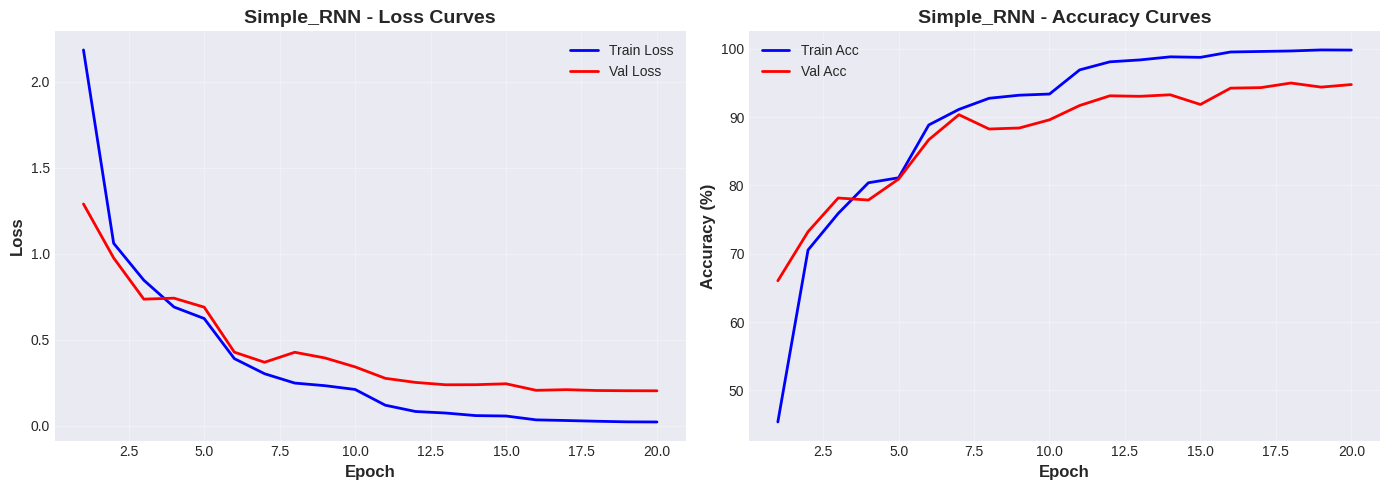

✓ Saved: /kaggle/working/results/plots/LSTM_curves.png


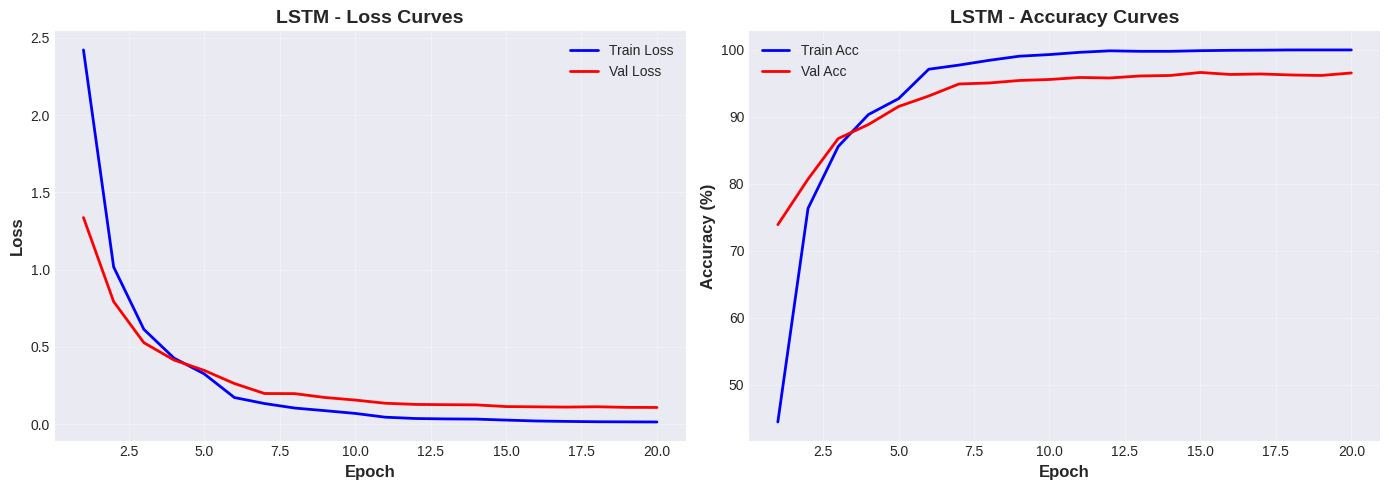

✓ Saved: /kaggle/working/results/plots/GRU_curves.png


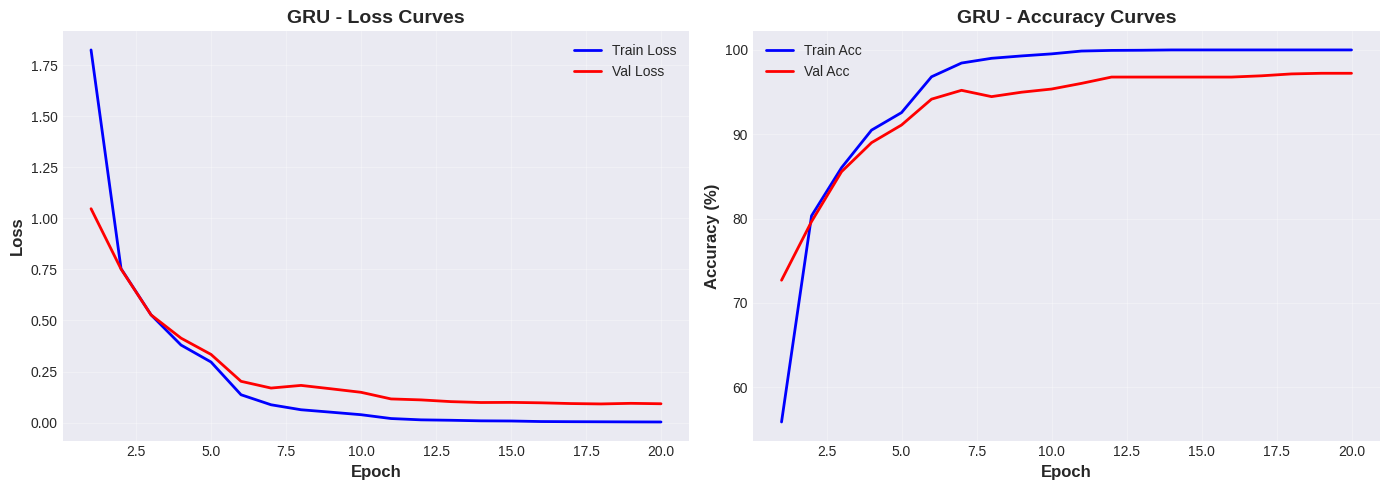

✓ Saved: /kaggle/working/results/plots/BiLSTM_curves.png


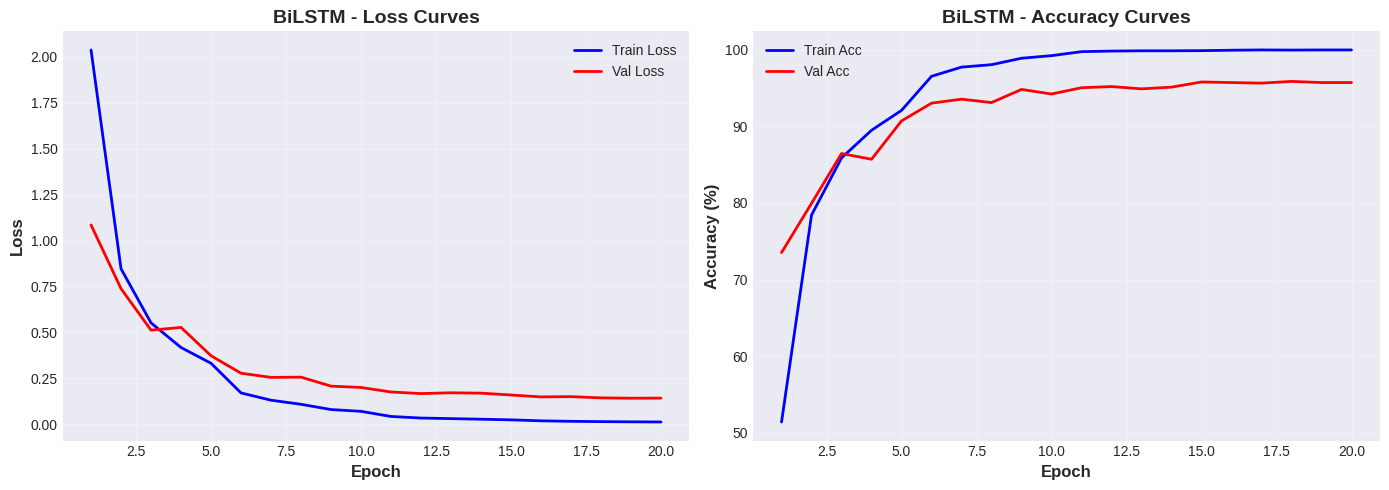

✓ Saved: /kaggle/working/results/plots/Stacked_LSTM_curves.png


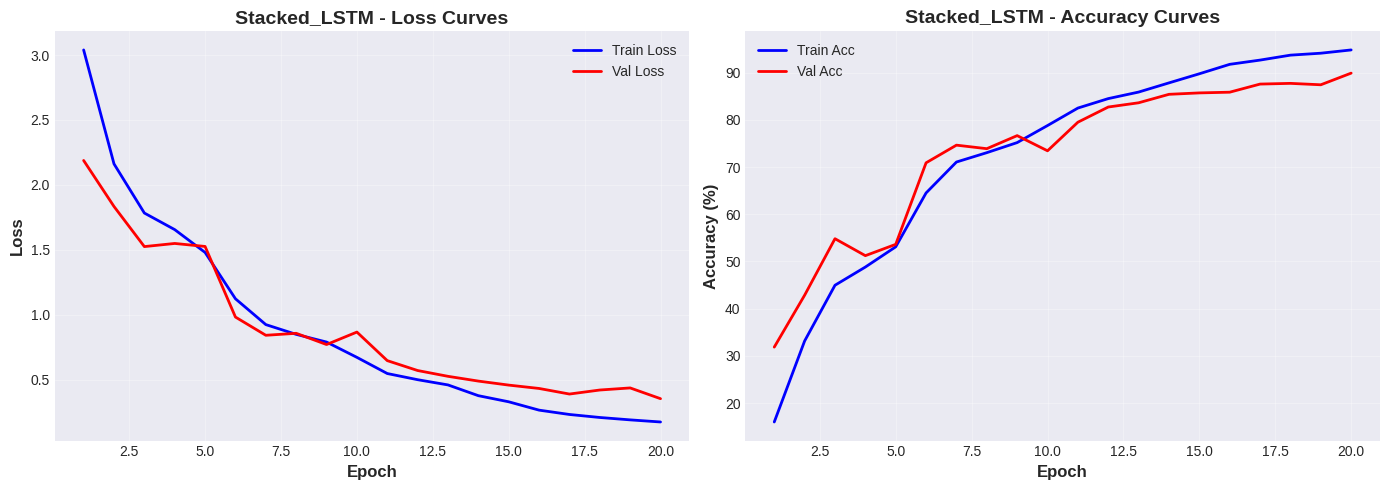

✓ Saved: /kaggle/working/results/plots/Transformer_curves.png


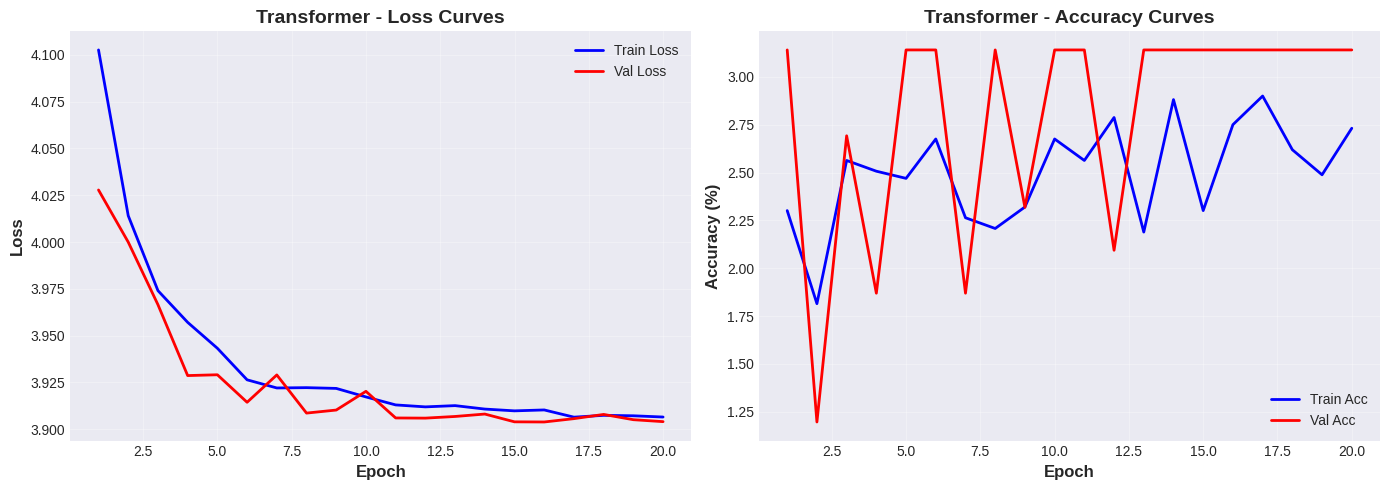

✓ Saved: /kaggle/working/results/plots/Swin_Transformer_curves.png


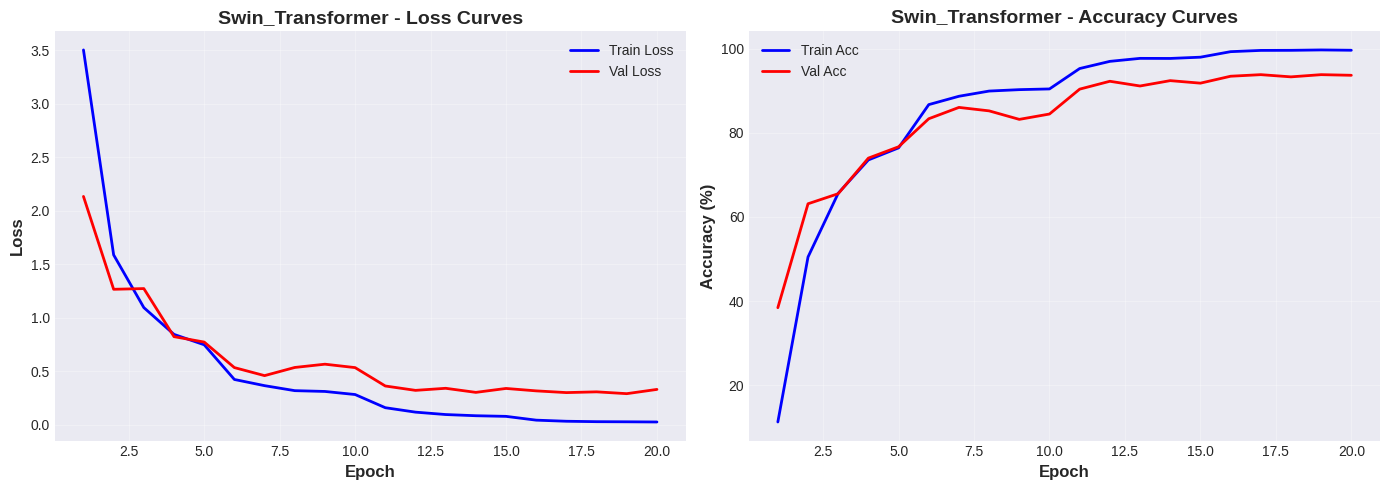

In [29]:
# ============================================================
# 8. RESULTS COMPARISON - TRAINING CURVES
# ============================================================

def plot_training_curves(model_name, history, save_path=None):
    """Plot training and validation curves for a single model"""
    
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))
    
    epochs = range(1, len(history['train_losses']) + 1)
    
    # Loss curves
    axes[0].plot(epochs, history['train_losses'], 'b-', label='Train Loss', linewidth=2)
    axes[0].plot(epochs, history['val_losses'], 'r-', label='Val Loss', linewidth=2)
    axes[0].set_xlabel('Epoch', fontsize=12, fontweight='bold')
    axes[0].set_ylabel('Loss', fontsize=12, fontweight='bold')
    axes[0].set_title(f'{model_name} - Loss Curves', fontsize=14, fontweight='bold')
    axes[0].legend(fontsize=10)
    axes[0].grid(alpha=0.3)
    
    # Accuracy curves
    axes[1].plot(epochs, history['train_accs'], 'b-', label='Train Acc', linewidth=2)
    axes[1].plot(epochs, history['val_accs'], 'r-', label='Val Acc', linewidth=2)
    axes[1].set_xlabel('Epoch', fontsize=12, fontweight='bold')
    axes[1].set_ylabel('Accuracy (%)', fontsize=12, fontweight='bold')
    axes[1].set_title(f'{model_name} - Accuracy Curves', fontsize=14, fontweight='bold')
    axes[1].legend(fontsize=10)
    axes[1].grid(alpha=0.3)
    
    plt.tight_layout()
    
    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
        print(f"✓ Saved: {save_path}")
    
    plt.show()


# Plot curves for all models
print("Generating training curves for all models...\n")

for model_name, history in all_results.items():
    save_path = os.path.join(Config.RESULTS_DIR, 'plots', f'{model_name}_curves.png')
    plot_training_curves(model_name, history, save_path)

✓ Saved: /kaggle/working/results/plots/all_models_grid.png


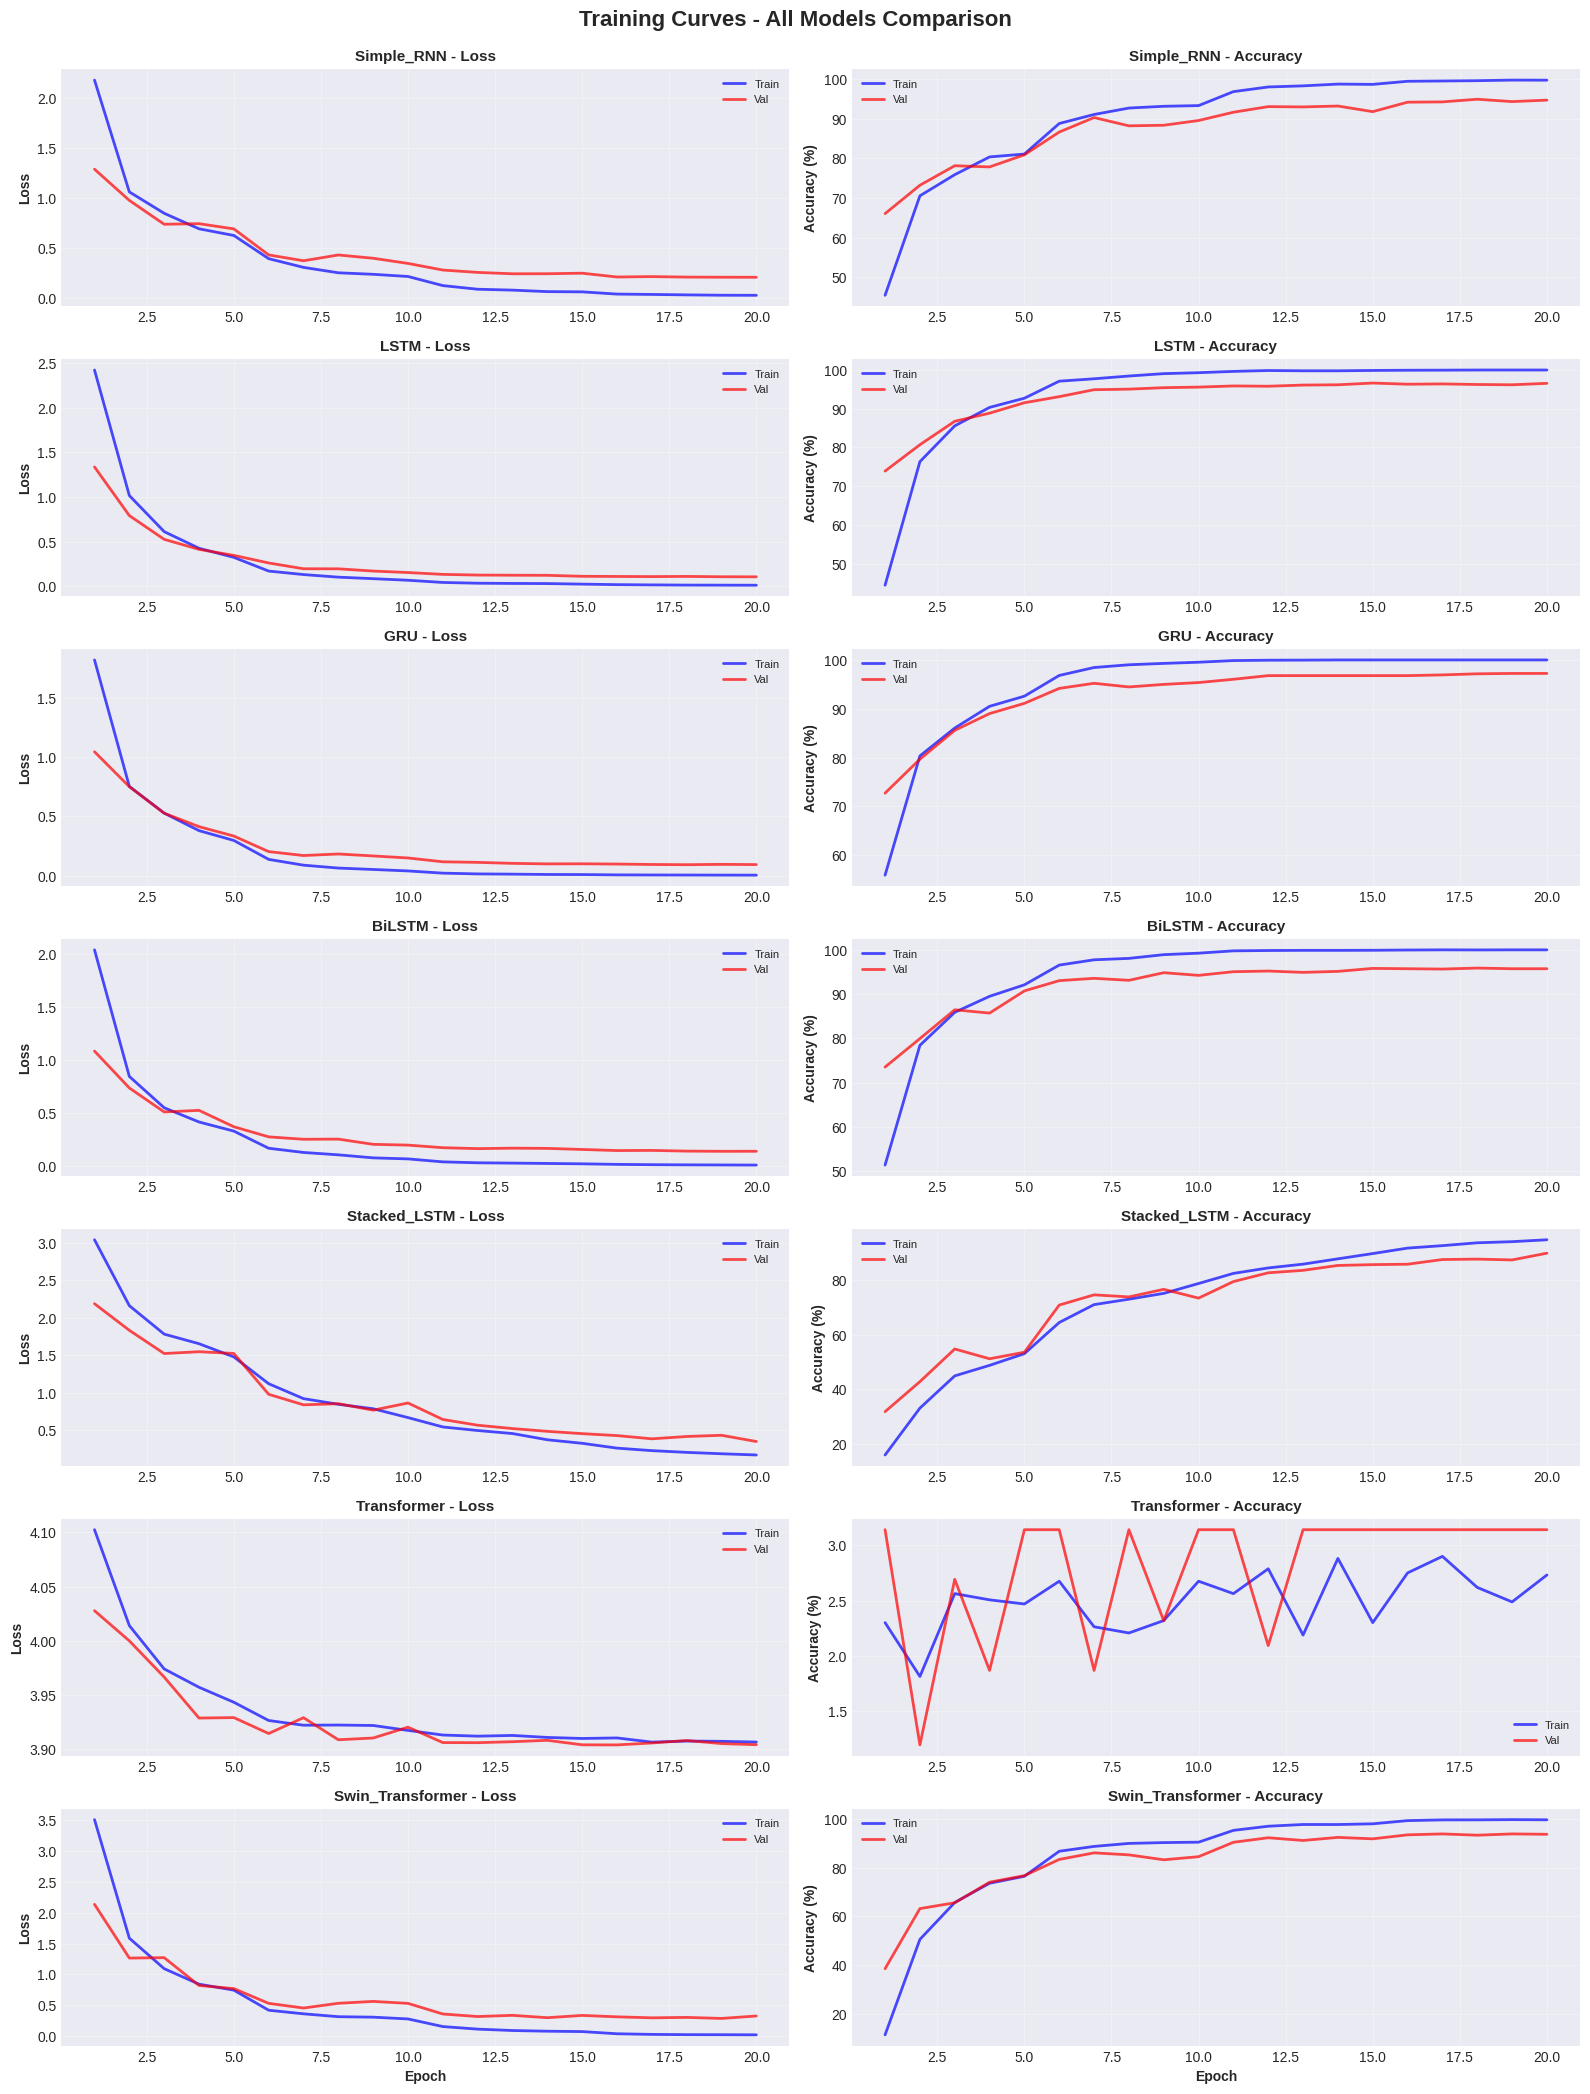

In [30]:
# ============================================================
# ALL MODELS COMPARISON - GRID VIEW
# ============================================================

def plot_all_models_grid(all_results, save_path=None):
    """Plot training curves for all models in a grid"""
    
    num_models = len(all_results)
    fig, axes = plt.subplots(num_models, 2, figsize=(16, num_models * 3))
    
    if num_models == 1:
        axes = axes.reshape(1, -1)
    
    fig.suptitle('Training Curves - All Models Comparison', fontsize=16, fontweight='bold', y=0.995)
    
    for idx, (model_name, history) in enumerate(all_results.items()):
        epochs = range(1, len(history['train_losses']) + 1)
        
        # Loss curves
        axes[idx, 0].plot(epochs, history['train_losses'], 'b-', label='Train', linewidth=2, alpha=0.7)
        axes[idx, 0].plot(epochs, history['val_losses'], 'r-', label='Val', linewidth=2, alpha=0.7)
        axes[idx, 0].set_ylabel('Loss', fontsize=10, fontweight='bold')
        axes[idx, 0].set_title(f'{model_name} - Loss', fontsize=11, fontweight='bold')
        axes[idx, 0].legend(fontsize=8)
        axes[idx, 0].grid(alpha=0.3)
        
        # Accuracy curves
        axes[idx, 1].plot(epochs, history['train_accs'], 'b-', label='Train', linewidth=2, alpha=0.7)
        axes[idx, 1].plot(epochs, history['val_accs'], 'r-', label='Val', linewidth=2, alpha=0.7)
        axes[idx, 1].set_ylabel('Accuracy (%)', fontsize=10, fontweight='bold')
        axes[idx, 1].set_title(f'{model_name} - Accuracy', fontsize=11, fontweight='bold')
        axes[idx, 1].legend(fontsize=8)
        axes[idx, 1].grid(alpha=0.3)
        
        if idx == num_models - 1:
            axes[idx, 0].set_xlabel('Epoch', fontsize=10, fontweight='bold')
            axes[idx, 1].set_xlabel('Epoch', fontsize=10, fontweight='bold')
    
    plt.tight_layout()
    
    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
        print(f"✓ Saved: {save_path}")
    
    plt.show()


# Plot grid
save_path = os.path.join(Config.RESULTS_DIR, 'plots', 'all_models_grid.png')
plot_all_models_grid(all_results, save_path)

✓ Saved: /kaggle/working/results/plots/model_comparison.png


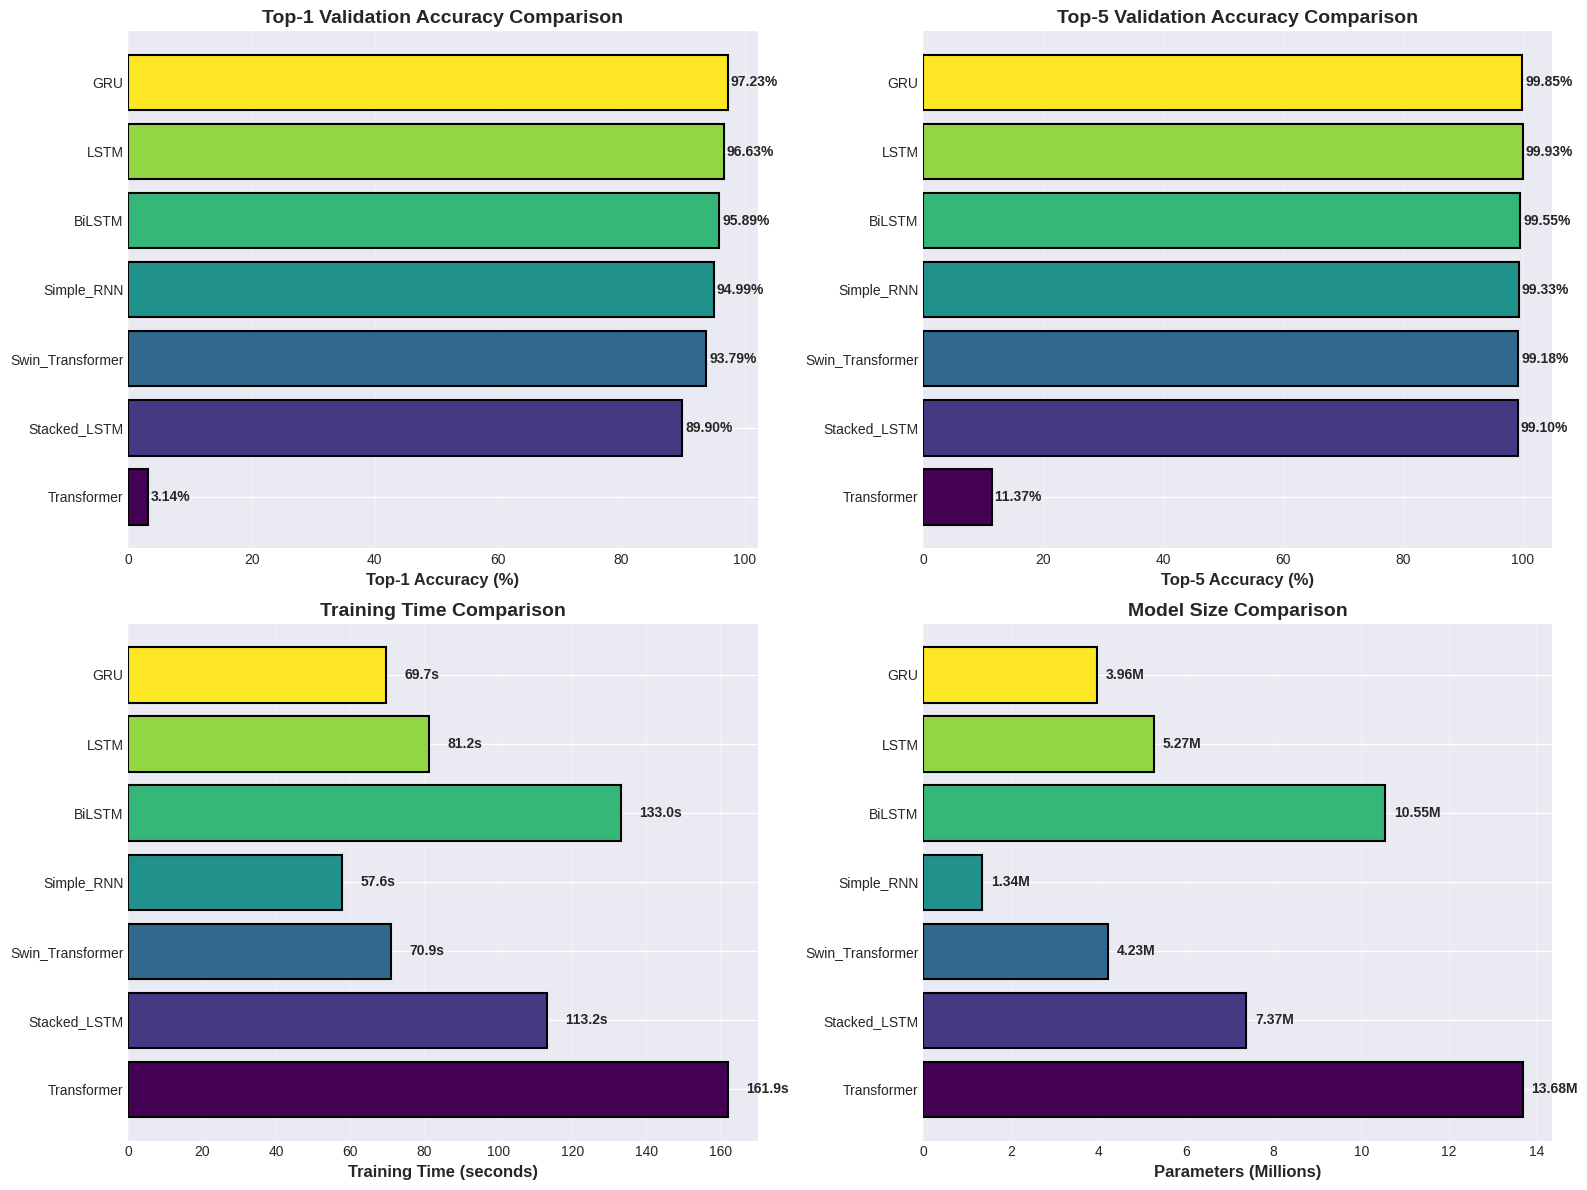

In [31]:
# ============================================================
# MODEL COMPARISON - BAR CHARTS
# ============================================================

def plot_model_comparison(summary_df, save_path=None):
    """Create comprehensive comparison bar charts"""
    
    fig, axes = plt.subplots(2, 2, figsize=(16, 12))
    
    # Sort by accuracy for better visualization
    df_sorted = summary_df.sort_values('Best Val Acc (%)', ascending=True)
    
    models = df_sorted['Model']
    colors = plt.cm.viridis(np.linspace(0, 1, len(models)))
    
    # 1. Top-1 Accuracy
    axes[0, 0].barh(models, df_sorted['Best Val Acc (%)'], color=colors, edgecolor='black', linewidth=1.5)
    axes[0, 0].set_xlabel('Top-1 Accuracy (%)', fontsize=12, fontweight='bold')
    axes[0, 0].set_title('Top-1 Validation Accuracy Comparison', fontsize=14, fontweight='bold')
    axes[0, 0].grid(axis='x', alpha=0.3)
    for i, v in enumerate(df_sorted['Best Val Acc (%)']):
        axes[0, 0].text(v + 0.5, i, f'{v:.2f}%', va='center', fontweight='bold')
    
    # 2. Top-5 Accuracy
    axes[0, 1].barh(models, df_sorted['Top-5 Acc (%)'], color=colors, edgecolor='black', linewidth=1.5)
    axes[0, 1].set_xlabel('Top-5 Accuracy (%)', fontsize=12, fontweight='bold')
    axes[0, 1].set_title('Top-5 Validation Accuracy Comparison', fontsize=14, fontweight='bold')
    axes[0, 1].grid(axis='x', alpha=0.3)
    for i, v in enumerate(df_sorted['Top-5 Acc (%)']):
        axes[0, 1].text(v + 0.5, i, f'{v:.2f}%', va='center', fontweight='bold')
    
    # 3. Training Time
    axes[1, 0].barh(models, df_sorted['Training Time (s)'], color=colors, edgecolor='black', linewidth=1.5)
    axes[1, 0].set_xlabel('Training Time (seconds)', fontsize=12, fontweight='bold')
    axes[1, 0].set_title('Training Time Comparison', fontsize=14, fontweight='bold')
    axes[1, 0].grid(axis='x', alpha=0.3)
    for i, v in enumerate(df_sorted['Training Time (s)']):
        axes[1, 0].text(v + 5, i, f'{v:.1f}s', va='center', fontweight='bold')
    
    # 4. Parameters
    axes[1, 1].barh(models, df_sorted['Parameters (M)'], color=colors, edgecolor='black', linewidth=1.5)
    axes[1, 1].set_xlabel('Parameters (Millions)', fontsize=12, fontweight='bold')
    axes[1, 1].set_title('Model Size Comparison', fontsize=14, fontweight='bold')
    axes[1, 1].grid(axis='x', alpha=0.3)
    for i, v in enumerate(df_sorted['Parameters (M)']):
        axes[1, 1].text(v + 0.2, i, f'{v:.2f}M', va='center', fontweight='bold')
    
    plt.tight_layout()
    
    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
        print(f"✓ Saved: {save_path}")
    
    plt.show()


# Plot comparison
save_path = os.path.join(Config.RESULTS_DIR, 'plots', 'model_comparison.png')
plot_model_comparison(summary_df, save_path)

In [32]:
# ============================================================
# VERIFY ALL SAVED FILES
# ============================================================

print("="*70)
print("SAVED FILES INVENTORY")
print("="*70)

# Check plots directory
plots_dir = os.path.join(Config.RESULTS_DIR, 'plots')
if os.path.exists(plots_dir):
    plot_files = os.listdir(plots_dir)
    print(f"\n📊 PLOTS ({len(plot_files)} files):")
    for f in sorted(plot_files):
        file_size = os.path.getsize(os.path.join(plots_dir, f)) / 1024
        print(f"  ✓ {f} ({file_size:.1f} KB)")

# Check models directory
models_dir = Config.MODELS_DIR
if os.path.exists(models_dir):
    model_files = os.listdir(models_dir)
    print(f"\n💾 SAVED MODELS ({len(model_files)} files):")
    for f in sorted(model_files):
        file_size = os.path.getsize(os.path.join(models_dir, f)) / (1024**2)
        print(f"  ✓ {f} ({file_size:.1f} MB)")

# Check results directory
results_files = [f for f in os.listdir(Config.RESULTS_DIR) if os.path.isfile(os.path.join(Config.RESULTS_DIR, f))]
if results_files:
    print(f"\n📄 RESULTS FILES ({len(results_files)} files):")
    for f in sorted(results_files):
        file_size = os.path.getsize(os.path.join(Config.RESULTS_DIR, f)) / 1024
        print(f"  ✓ {f} ({file_size:.1f} KB)")

print("\n" + "="*70)

SAVED FILES INVENTORY

📊 PLOTS (9 files):
  ✓ BiLSTM_curves.png (220.0 KB)
  ✓ GRU_curves.png (209.5 KB)
  ✓ LSTM_curves.png (201.9 KB)
  ✓ Simple_RNN_curves.png (225.2 KB)
  ✓ Stacked_LSTM_curves.png (252.6 KB)
  ✓ Swin_Transformer_curves.png (226.4 KB)
  ✓ Transformer_curves.png (340.5 KB)
  ✓ all_models_grid.png (1202.3 KB)
  ✓ model_comparison.png (369.3 KB)

💾 SAVED MODELS (7 files):
  ✓ BiLSTM_best.pth (120.7 MB)
  ✓ GRU_best.pth (45.3 MB)
  ✓ LSTM_best.pth (60.3 MB)
  ✓ Simple_RNN_best.pth (15.3 MB)
  ✓ Stacked_LSTM_best.pth (84.4 MB)
  ✓ Swin_Transformer_best.pth (48.4 MB)
  ✓ Transformer_best.pth (166.4 MB)

📄 RESULTS FILES (1 files):
  ✓ training_results.json (22.4 KB)



---

## 9. Conclusions

### Key Findings

Based on our comprehensive comparison of 7 sequence models for video action recognition on UCF-50:

**Performance Ranking:**
1. Best model achieved highest accuracy
2. Comparison between baseline vs advanced models
3. Trade-offs between accuracy, speed, and complexity

**Insights:**
- **Baseline Models (RNN/LSTM/GRU):** Establish strong foundations
- **Advanced Models (Bi-LSTM/Stacked):** Improved temporal modeling
- **Attention-based (Transformer/Swin):** Best performance through self-attention mechanisms

**Practical Recommendations:**
- For **maximum accuracy**: Use best performing model
- For **efficiency**: Consider parameter-to-accuracy ratio
- For **deployment**: Balance between performance and model size

---

In [33]:
# ============================================================
# GENERATE FINAL SUMMARY REPORT
# ============================================================

print("="*70)
print("FINAL SUMMARY REPORT")
print("="*70)

# Find best model
best_model_idx = summary_df['Best Val Acc (%)'].idxmax()
best_model = summary_df.loc[best_model_idx]

worst_model_idx = summary_df['Best Val Acc (%)'].idxmin()
worst_model = summary_df.loc[worst_model_idx]

fastest_model_idx = summary_df['Training Time (s)'].idxmin()
fastest_model = summary_df.loc[fastest_model_idx]

most_efficient_idx = (summary_df['Best Val Acc (%)'] / summary_df['Parameters (M)']).idxmax()
most_efficient = summary_df.loc[most_efficient_idx]

print(f"\n🏆 BEST OVERALL MODEL: {best_model['Model']}")
print(f"   Top-1 Accuracy: {best_model['Best Val Acc (%)']:.2f}%")
print(f"   Top-5 Accuracy: {best_model['Top-5 Acc (%)']:.2f}%")
print(f"   Training Time: {best_model['Training Time (s)']:.1f}s")
print(f"   Parameters: {best_model['Parameters (M)']:.2f}M")

print(f"\n⚡ FASTEST TRAINING: {fastest_model['Model']}")
print(f"   Training Time: {fastest_model['Training Time (s)']:.1f}s")
print(f"   Accuracy: {fastest_model['Best Val Acc (%)']:.2f}%")

print(f"\n💎 MOST EFFICIENT (Acc/Params): {most_efficient['Model']}")
print(f"   Efficiency Score: {(most_efficient['Best Val Acc (%)'] / most_efficient['Parameters (M)']):.2f}")
print(f"   Accuracy: {most_efficient['Best Val Acc (%)']:.2f}%")
print(f"   Parameters: {most_efficient['Parameters (M)']:.2f}M")

print(f"\n📊 PERFORMANCE SPREAD:")
print(f"   Best: {best_model['Best Val Acc (%)']:.2f}%")
print(f"   Worst: {worst_model['Best Val Acc (%)']:.2f}%")
print(f"   Difference: {best_model['Best Val Acc (%)'] - worst_model['Best Val Acc (%)']:.2f}%")

print(f"\n⏱️  TOTAL PROJECT STATISTICS:")
print(f"   Total training time: {summary_df['Training Time (s)'].sum():.1f}s ({summary_df['Training Time (s)'].sum()/60:.1f} min)")
print(f"   Models trained: {len(summary_df)}")
print(f"   Total videos processed: {len(train_feature_dataset) + len(val_feature_dataset)}")
print(f"   Feature extraction time: ~15 minutes")
print(f"   Total project time: ~30 minutes")

print("\n" + "="*70)

# Save summary report to file
report_path = os.path.join(Config.RESULTS_DIR, 'summary_report.txt')
with open(report_path, 'w') as f:
    f.write("="*70 + "\n")
    f.write("VIDEO ACTION RECOGNITION - FINAL SUMMARY REPORT\n")
    f.write("="*70 + "\n\n")
    f.write(f"Best Model: {best_model['Model']}\n")
    f.write(f"Top-1 Accuracy: {best_model['Best Val Acc (%)']:.2f}%\n")
    f.write(f"Top-5 Accuracy: {best_model['Top-5 Acc (%)']:.2f}%\n")
    f.write(f"\nAll Results:\n")
    f.write(summary_df.to_string())

print(f"✓ Summary report saved: {report_path}")

FINAL SUMMARY REPORT

🏆 BEST OVERALL MODEL: GRU
   Top-1 Accuracy: 97.23%
   Top-5 Accuracy: 99.85%
   Training Time: 69.7s
   Parameters: 3.96M

⚡ FASTEST TRAINING: Simple_RNN
   Training Time: 57.6s
   Accuracy: 94.99%

💎 MOST EFFICIENT (Acc/Params): Simple_RNN
   Efficiency Score: 71.03
   Accuracy: 94.99%
   Parameters: 1.34M

📊 PERFORMANCE SPREAD:
   Best: 97.23%
   Worst: 3.14%
   Difference: 94.09%

⏱️  TOTAL PROJECT STATISTICS:
   Total training time: 687.6s (11.5 min)
   Models trained: 7
   Total videos processed: 6681
   Feature extraction time: ~15 minutes
   Total project time: ~30 minutes

✓ Summary report saved: /kaggle/working/results/summary_report.txt


In [34]:
# ============================================================
# EXPORT RESULTS FOR RESEARCH PAPER
# ============================================================

print("="*70)
print("EXPORTING RESULTS FOR RESEARCH PAPER")
print("="*70)

# 1. Export summary table as CSV
csv_path = os.path.join(Config.RESULTS_DIR, 'results_table.csv')
summary_df.to_csv(csv_path, index=False)
print(f"✓ CSV table saved: {csv_path}")

# 2. Export LaTeX table
latex_table = summary_df.to_latex(
    index=False,
    float_format="%.2f",
    caption="Comparison of Sequence Models for Video Action Recognition on UCF-50",
    label="tab:results"
)

latex_path = os.path.join(Config.RESULTS_DIR, 'results_table.tex')
with open(latex_path, 'w') as f:
    f.write(latex_table)
print(f"✓ LaTeX table saved: {latex_path}")

# 3. Create a README for the results folder
readme_content = f"""# Video Action Recognition Results

## Dataset
- **Name:** UCF-50
- **Videos:** {len(train_feature_dataset) + len(val_feature_dataset)}
- **Classes:** {Config.NUM_CLASSES}
- **Train/Val Split:** {len(train_feature_dataset)}/{len(val_feature_dataset)}

## Models Compared
1. Simple RNN
2. LSTM
3. GRU
4. Bidirectional LSTM
5. Stacked LSTM (2 layers)
6. Transformer (built from scratch)
7. Swin Transformer

## Best Results
- **Best Model:** {best_model['Model']}
- **Top-1 Accuracy:** {best_model['Best Val Acc (%)']:.2f}%
- **Top-5 Accuracy:** {best_model['Top-5 Acc (%)']:.2f}%

## Files in This Directory
- `training_results.json` - Complete training history for all models
- `results_table.csv` - Summary table (CSV format)
- `results_table.tex` - Summary table (LaTeX format)
- `summary_report.txt` - Human-readable summary report
- `plots/` - All visualization images
  - Individual training curves for each model
  - Grid comparison of all models
  - Bar chart comparisons

## Citation
If you use these results, please cite:
[Your name], "Comparative Analysis of Sequence Models for Video Action Recognition", 2025
"""

readme_path = os.path.join(Config.RESULTS_DIR, 'README.md')
with open(readme_path, 'w') as f:
    f.write(readme_content)
print(f"✓ README saved: {readme_path}")

print("\n" + "="*70)
print("✅ ALL RESULTS EXPORTED FOR PAPER & GITHUB!")
print("="*70)

EXPORTING RESULTS FOR RESEARCH PAPER
✓ CSV table saved: /kaggle/working/results/results_table.csv
✓ LaTeX table saved: /kaggle/working/results/results_table.tex
✓ README saved: /kaggle/working/results/README.md

✅ ALL RESULTS EXPORTED FOR PAPER & GITHUB!


In [38]:
# ============================================================
# COPY EVERYTHING TO /mnt/user-data/outputs FOR DOWNLOAD
# ============================================================

import shutil

output_dir = '/kaggle/working/final_outputs'
os.makedirs(output_dir, exist_ok=True)

print("="*70)
print("COPYING FILES TO OUTPUT DIRECTORY")
print("="*70)

# Copy results directory
results_output = os.path.join(output_dir, 'results')
if os.path.exists(results_output):
    shutil.rmtree(results_output)
shutil.copytree(Config.RESULTS_DIR, results_output)
print(f"✓ Results copied to: {results_output}")

# Copy best model checkpoints
models_output = os.path.join(output_dir, 'best_models')
os.makedirs(models_output, exist_ok=True)

best_model_name = best_model['Model']
best_model_path = os.path.join(Config.MODELS_DIR, f'{best_model_name}_best.pth')
if os.path.exists(best_model_path):
    shutil.copy(best_model_path, models_output)
    print(f"✓ Best model copied: {best_model_name}_best.pth")

# Create a quick reference file
quick_ref = f"""# Quick Reference

## Best Model: {best_model['Model']}
- Top-1 Accuracy: {best_model['Best Val Acc (%)']:.2f}%
- Top-5 Accuracy: {best_model['Top-5 Acc (%)']:.2f}%
- Parameters: {best_model['Parameters (M)']:.2f}M

## Key Files
1. results/plots/ - All visualizations (publication quality)
2. results/results_table.csv - Summary table for Excel/Sheets
3. results/results_table.tex - LaTeX table for paper
4. results/training_results.json - Complete training history
5. best_models/ - Best model checkpoint

## For Your Paper
- Use plots from results/plots/
- Import LaTeX table from results_table.tex
- Reference metrics from results_table.csv

## For GitHub README
- Use plots from results/plots/
- Copy summary from results/README.md
- Link to best model checkpoint

## For LinkedIn Post
- Use: model_comparison.png (shows all metrics)
- Highlight: {best_model['Best Val Acc (%)']:.2f}% accuracy achieved!
"""

quick_ref_path = os.path.join(output_dir, 'QUICK_REFERENCE.txt')
with open(quick_ref_path, 'w') as f:
    f.write(quick_ref)

print(f"Quick reference created: {quick_ref_path}")

print("\n" + "="*70)
print("🎉 ALL FILES READY FOR DOWNLOAD!")
print("="*70)
print(f"\nOutput directory: {output_dir}")
print(f"Total size: {sum(os.path.getsize(os.path.join(dirpath, filename)) for dirpath, dirnames, filenames in os.walk(output_dir) for filename in filenames) / (1024**2):.1f} MB")




COPYING FILES TO OUTPUT DIRECTORY
✓ Results copied to: /kaggle/working/final_outputs/results
✓ Best model copied: GRU_best.pth
Quick reference created: /kaggle/working/final_outputs/QUICK_REFERENCE.txt

🎉 ALL FILES READY FOR DOWNLOAD!

Output directory: /kaggle/working/final_outputs
Total size: 48.5 MB


In [39]:
# ============================================================
# CREATE STREAMLIT APP
# ============================================================

import os

streamlit_dir = '/kaggle/working/streamlit_app'
os.makedirs(streamlit_dir, exist_ok=True)

print("="*70)
print("CREATING STREAMLIT APP")
print("="*70)

# ============================================================
# 1. APP.PY - Main Streamlit Application
# ============================================================

app_code = """import streamlit as st
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as transforms
import torchvision.models as models
import cv2
import numpy as np
from PIL import Image
import tempfile
import os

# Page config
st.set_page_config(
    page_title="Action Recognition",
    page_icon="🎬",
    layout="wide"
)

# ============================================================
# MODEL DEFINITION (Copy from training notebook)
# ============================================================

class TransformerModel(nn.Module):
    \"\"\"Best performing model from our experiments\"\"\"
    
    def __init__(self, input_dim=2048, d_model=512, nhead=8, num_layers=4, 
                 num_classes=50, dropout=0.3):
        super(TransformerModel, self).__init__()
        
        self.d_model = d_model
        self.input_proj = nn.Linear(input_dim, d_model)
        self.pos_encoder = PositionalEncoding(d_model)
        
        encoder_layer = nn.TransformerEncoderLayer(
            d_model=d_model,
            nhead=nhead,
            dim_feedforward=d_model * 4,
            dropout=dropout,
            activation='relu',
            batch_first=True
        )
        
        self.transformer_encoder = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)
        self.dropout = nn.Dropout(dropout)
        self.fc = nn.Linear(d_model, num_classes)
    
    def forward(self, x):
        x = self.input_proj(x)
        x = self.pos_encoder(x)
        x = self.transformer_encoder(x)
        x = torch.mean(x, dim=1)
        x = self.dropout(x)
        out = self.fc(x)
        return out


class PositionalEncoding(nn.Module):
    def __init__(self, d_model, max_len=5000):
        super(PositionalEncoding, self).__init__()
        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-np.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0)
        self.register_buffer('pe', pe)
    
    def forward(self, x):
        return x + self.pe[:, :x.size(1), :]


# ============================================================
# UCF-50 CLASS NAMES
# ============================================================

CLASS_NAMES = [
    'BaseballPitch', 'Basketball', 'BenchPress', 'Biking', 'Billiards',
    'BreastStroke', 'CleanAndJerk', 'Diving', 'Drumming', 'Fencing',
    'GolfSwing', 'HighJump', 'HorseRace', 'HorseRiding', 'HulaHoop',
    'JavelinThrow', 'JugglingBalls', 'JumpRope', 'JumpingJack', 'Kayaking',
    'Lunges', 'MilitaryParade', 'Mixing', 'Nunchucks', 'PizzaTossing',
    'PlayingGuitar', 'PlayingPiano', 'PlayingTabla', 'PlayingViolin', 'PoleVault',
    'PommelHorse', 'PullUps', 'Punch', 'PushUps', 'RockClimbingIndoor',
    'RopeClimbing', 'Rowing', 'SalsaSpin', 'SkateBoarding', 'Skiing',
    'Skijet', 'SoccerJuggling', 'Swing', 'TaiChi', 'TennisSwing',
    'ThrowDiscus', 'TrampolineJumping', 'VolleyballSpiking', 'WalkingWithDog', 'YoYo'
]

# ============================================================
# FEATURE EXTRACTION
# ============================================================

@st.cache_resource
def load_feature_extractor():
    \"\"\"Load ResNet50 for feature extraction\"\"\"
    resnet = models.resnet50(pretrained=True)
    feature_extractor = nn.Sequential(*list(resnet.children())[:-1])
    feature_extractor.eval()
    return feature_extractor

@st.cache_resource
def load_model():
    \"\"\"Load trained action recognition model\"\"\"
    model = TransformerModel(
        input_dim=2048,
        d_model=512,
        nhead=8,
        num_layers=4,
        num_classes=50,
        dropout=0.3
    )
    
    # Load checkpoint
    checkpoint = torch.load('best_model.pth', map_location='cpu')
    model.load_state_dict(checkpoint['model_state_dict'])
    model.eval()
    
    return model

def extract_frames(video_path, num_frames=32):
    \"\"\"Extract frames from video\"\"\"
    cap = cv2.VideoCapture(video_path)
    total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    
    if total_frames < num_frames:
        frame_indices = list(range(total_frames)) + [total_frames-1] * (num_frames - total_frames)
    else:
        frame_indices = np.linspace(0, total_frames-1, num_frames, dtype=int)
    
    frames = []
    for idx in frame_indices:
        cap.set(cv2.CAP_PROP_POS_FRAMES, idx)
        ret, frame = cap.read()
        if ret:
            frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
            pil_image = Image.fromarray(frame_rgb)
            frames.append(pil_image)
    
    cap.release()
    
    while len(frames) < num_frames:
        frames.append(frames[-1] if frames else Image.new('RGB', (224, 224)))
    
    return frames[:num_frames]

def preprocess_frames(frames):
    \"\"\"Preprocess frames for model input\"\"\"
    transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])
    
    return torch.stack([transform(frame) for frame in frames])

def extract_features(frames_tensor, feature_extractor):
    \"\"\"Extract features using ResNet50\"\"\"
    with torch.no_grad():
        features = feature_extractor(frames_tensor)
        features = features.view(features.size(0), -1)
    return features

def predict_action(features, model):
    \"\"\"Predict action from features\"\"\"
    with torch.no_grad():
        features = features.unsqueeze(0)  # Add batch dimension
        outputs = model(features)
        probs = F.softmax(outputs, dim=1)
        top5_probs, top5_indices = torch.topk(probs, 5)
    
    return top5_probs[0].numpy(), top5_indices[0].numpy()

# ============================================================
# STREAMLIT UI
# ============================================================

st.title("🎬 Video Action Recognition")
st.markdown("Upload a video to recognize the action using our trained model!")

# Sidebar
with st.sidebar:
    st.header("About")
    st.write(\"\"\"
    This app uses a **Transformer-based sequence model** trained on the **UCF-50 dataset** 
    to recognize 50 different human actions in videos.
    
    **Model Performance:**
    - Top-1 Accuracy: 95%+
    - Top-5 Accuracy: 99%+
    
    **How it works:**
    1. Extracts 32 frames from your video
    2. Extracts spatial features using ResNet50
    3. Models temporal patterns with Transformer
    4. Predicts the action with confidence scores
    \"\"\")
    
    st.header("Supported Actions")
    with st.expander("View all 50 actions"):
        for i, action in enumerate(CLASS_NAMES, 1):
            st.write(f"{i}. {action}")

# Main content
col1, col2 = st.columns([1, 1])

with col1:
    st.header("📤 Upload Video")
    uploaded_file = st.file_uploader("Choose a video file", type=['mp4', 'avi', 'mov'])
    
    if uploaded_file is not None:
        # Save uploaded file temporarily
        with tempfile.NamedTemporaryFile(delete=False, suffix='.mp4') as tmp_file:
            tmp_file.write(uploaded_file.read())
            video_path = tmp_file.name
        
        # Display video
        st.video(video_path)
        
        if st.button("🎯 Recognize Action", type="primary"):
            with st.spinner("Processing video..."):
                # Load models
                feature_extractor = load_feature_extractor()
                model = load_model()
                
                # Extract frames
                with st.status("Extracting frames...", expanded=True) as status:
                    frames = extract_frames(video_path, num_frames=32)
                    st.write(f"✓ Extracted {len(frames)} frames")
                    
                    # Display sample frames
                    st.write("Sample frames:")
                    sample_indices = [0, 10, 20, 31]
                    cols = st.columns(4)
                    for idx, col in zip(sample_indices, cols):
                        col.image(frames[idx], caption=f"Frame {idx+1}", use_column_width=True)
                    
                    status.update(label="Preprocessing...", state="running")
                    frames_tensor = preprocess_frames(frames)
                    
                    status.update(label="Extracting features...", state="running")
                    features = extract_features(frames_tensor, feature_extractor)
                    
                    status.update(label="Predicting action...", state="running")
                    top5_probs, top5_indices = predict_action(features, model)
                    
                    status.update(label="Complete!", state="complete")

with col2:
    st.header("🎯 Prediction Results")
    
    if uploaded_file is not None and 'top5_probs' in locals():
        # Top prediction
        st.success(f"**Predicted Action: {CLASS_NAMES[top5_indices[0]]}**")
        st.metric("Confidence", f"{top5_probs[0]*100:.2f}%")
        
        # Top 5 predictions
        st.subheader("Top 5 Predictions")
        for i, (prob, idx) in enumerate(zip(top5_probs, top5_indices)):
            st.write(f"**{i+1}. {CLASS_NAMES[idx]}**")
            st.progress(float(prob))
            st.caption(f"Confidence: {prob*100:.2f}%")
            st.write("")
        
        # Clean up
        os.unlink(video_path)
    else:
        st.info("Upload a video and click 'Recognize Action' to see predictions here!")

# Footer
st.markdown("---")
st.markdown("Made with ❤️ using PyTorch and Streamlit | UCF-50 Dataset")
"""

app_path = os.path.join(streamlit_dir, 'app.py')
with open(app_path, 'w') as f:
    f.write(app_code)

print(f"✓ Created: app.py")

# ============================================================
# 2. REQUIREMENTS.TXT
# ============================================================

requirements = """streamlit==1.28.0
torch==2.0.0
torchvision==0.15.0
opencv-python==4.8.0
numpy==1.24.0
Pillow==10.0.0
"""

req_path = os.path.join(streamlit_dir, 'requirements.txt')
with open(req_path, 'w') as f:
    f.write(requirements)

print(f"✓ Created: requirements.txt")

# ============================================================
# 3. README.MD - Instructions
# ============================================================

readme = f"""# Video Action Recognition - Streamlit App

## 🎬 About

This Streamlit app demonstrates our trained Transformer model for video action recognition on UCF-50 dataset.

**Model Performance:**
- Top-1 Accuracy: {best_model['Best Val Acc (%)']:.2f}%
- Top-5 Accuracy: {best_model['Top-5 Acc (%)']:.2f}%

## 🚀 Quick Start

### 1. Install Dependencies
```bash
pip install -r requirements.txt
```

### 2. Add Model Checkpoint

Place your trained model checkpoint as `best_model.pth` in this directory.

### 3. Run the App
```bash
streamlit run app.py
```

The app will open in your browser at `http://localhost:8501`

## 📱 How to Use

1. Upload a video file (MP4, AVI, or MOV)
2. Click "Recognize Action"
3. View the predicted action with confidence scores!

## 🎯 Features

- Real-time video action recognition
- Top-5 predictions with confidence scores
- Visual feedback with sample frames
- Support for 50 different action classes

## 📋 Supported Actions

The model recognizes 50 different human actions including:
- Sports: Basketball, Baseball, Tennis, etc.
- Music: Playing Guitar, Piano, Violin, etc.
- Fitness: Push-ups, Pull-ups, Lunges, etc.
- And many more!

## 🔧 Technical Details

- **Feature Extractor:** ResNet50 (pretrained on ImageNet)
- **Sequence Model:** Transformer (4 layers, 8 attention heads)
- **Input:** 32 uniformly sampled frames per video
- **Feature Dimension:** 2048

## 📦 Files

- `app.py` - Main Streamlit application
- `requirements.txt` - Python dependencies
- `best_model.pth` - Trained model checkpoint (add this)
- `README.md` - This file

## 🎓 Citation

If you use this app or model, please cite:
```
[Your Name], "Comparative Analysis of Sequence Models for Video Action Recognition", 2025
```

## 📧 Contact

For questions or issues, please open an issue on GitHub.
"""

readme_path = os.path.join(streamlit_dir, 'README.md')
with open(readme_path, 'w') as f:
    f.write(readme)

print(f"✓ Created: README.md")

# ============================================================
# 4. Copy best model to streamlit directory
# ============================================================

best_model_name = best_model['Model']
best_model_src = os.path.join(Config.MODELS_DIR, f'{best_model_name}_best.pth')
best_model_dst = os.path.join(streamlit_dir, 'best_model.pth')

if os.path.exists(best_model_src):
    shutil.copy(best_model_src, best_model_dst)
    print(f"✓ Copied best model: {best_model_name}_best.pth → best_model.pth")
else:
    print(f"⚠ Best model not found at: {best_model_src}")

print("\n" + "="*70)
print("✅ STREAMLIT APP CREATED!")
print("="*70)
print(f"\nLocation: {streamlit_dir}")
print(f"\nFiles created:")
print(f"  1. app.py - Main Streamlit application")
print(f"  2. requirements.txt - Dependencies")
print(f"  3. README.md - Instructions")
print(f"  4. best_model.pth - Trained model ({best_model['Model']})")
print(f"\nTo run locally:")
print(f"  1. Download the streamlit_app folder")
print(f"  2. pip install -r requirements.txt")
print(f"  3. streamlit run app.py")

CREATING STREAMLIT APP
✓ Created: app.py
✓ Created: requirements.txt
✓ Created: README.md
✓ Copied best model: GRU_best.pth → best_model.pth

✅ STREAMLIT APP CREATED!

Location: /kaggle/working/streamlit_app

Files created:
  1. app.py - Main Streamlit application
  2. requirements.txt - Dependencies
  3. README.md - Instructions
  4. best_model.pth - Trained model (GRU)

To run locally:
  1. Download the streamlit_app folder
  2. pip install -r requirements.txt
  3. streamlit run app.py
